# Eff. matching to GEN particle


   * [Efficiency vs $\eta$](#Effinciency-vs-$\eta$)
   * [Efficiency vs $p_{T}$](#Efficiency-vs-$p_{T}$)
   * [Turn-on curves](#Turn-on-curves)


In [18]:
import sys
sys.path.insert(0, '..')
# sys.path.insert(1, '../python/')
sys.path.insert(1, 'python/')

import ROOT
# import python.l1THistos as histos
import math
import uuid
import pandas as pd

import webpager as wp

from drawingTools import *

# ROOT.enableJSVis()
ROOT.enableJSVis()

#from drawingTools import *
normalized_histos = list()

In [19]:

samples = [
    HistoFile('ttbar_PU200_jeteff', 'PU200', 'v200A.100C', 'ttbar-125X', 'ttbar 12.5.X'),
]


In [20]:
for smp in samples:
    smp.print_primitives()


<HistoFile ../plots/histos_ttbar_PU200_jeteff_v200A.100C.root, ttbar-125X>
--- HistoClass: 
['JetHistos', 'JetResoHistos', 'HistoSetEff']
--- TPs: 
['PFJets']
--- TP selections:
{'PFJets': ['all', 'Pt40', 'Pt30']}
--- GEN selections:
{'PFJets': ['GENJEtaEE', 'GENJPt30', 'GENJEtaEB', 'GENJ']}


In [21]:
import python.collections as collections
import python.selections as selections
# this is needed to get all the labels defined in cfg modules
import python.plotters_config 
from cfg import *


labels_dict = {}

evm = collections.EventManager()
labels_dict.update(evm.get_labels())
selm = selections.SelectionManager()
labels_dict.update(selm.get_labels())



# #  ==== labels ===============================================
# tp_labels = histo_primitives[['data', 'data_label']].drop_duplicates().set_index('data').T.to_dict('records')[0]
# tp_selection_labels = histo_primitives[['data_sel', 'data_sel_label']].drop_duplicates().set_index('data_sel').T.to_dict('records')[0]
# gen_selection_labels = histo_primitives[['gen_sel', 'gen_sel_label']].drop_duplicates().set_index('gen_sel').T.to_dict('records')[0]





In [22]:
%%time

import python.l1THistos as histos

hplot = HPlot(samples, labels_dict)
hplot.create_histo_proxies(histos.HistoSetEff)



--- JetHistos
# of plots: 480
# of primitives: 12
--- JetResoHistos
# of plots: 1680
# of primitives: 12
--- GenParticleHistos
# of plots: 1440
# of primitives: 12
CPU times: user 13.6 ms, sys: 2.99 ms, total: 16.6 ms
Wall time: 16.2 ms


In [23]:
for tp in hplot.tps():
    print ('TP: {}'.format(tp))
    print (hplot.data[hplot.data.tp == tp].tp_sel.unique())
    print (hplot.data[hplot.data.tp == tp].gen_sel.unique())

TP: PFJets
['all' 'Pt40' 'Pt30']
['GENJPt30' 'GENJEtaEB' 'GENJ' 'GENJEtaEE']


In [24]:
# print (dir(samples[0]))
# samples[0].histo_file.ls()
samples

[<HistoFile ../plots/histos_ttbar_PU200_jeteff_v200A.100C.root, ttbar-125X>]

In [25]:
# import python.calibrations as calib
# calib_mgr = calib.CalibManager()
# calib_mgr.set_pt_wps_version('data/rate_pt_wps_v160A.91G.json')
# rate_pt_wps = calib_mgr.get_pt_wps()
# print(rate_pt_wps)
# data_selections = calib.rate_pt_wps_selections(
# rate_pt_wps, 'TkEleEE')
# # data_selections = calib.rate_pt_wps_selections(
# # rate_pt_wps, 'TkEleL2')
# data_selections = calib.rate_pt_wps_selections(
# rate_pt_wps, 'TkEmL2')
# data_selections = calib.rate_pt_wps_selections(
# rate_pt_wps, 'TkEleL2')

# for sel in data_selections:
#     print (sel.selection)

# print(data_selections)
# selm = selections.SelectionManager()
# # labels_dict.update(selm.get_labels())
# hplot.labels_dict.update(selm.get_labels())


In [26]:
%%time

# ton_samples = hplot.data['sample'].unique()


for smp in hplot.data['sample'].unique():
    print ('Sample: {}'.format(smp))
    for pu in hplot.data[(hplot.data['sample'] == smp)].pu.unique():
        for tp in ['PFJets']:
            print ('PU: {}, TP: {}'.format(pu, tp))
            for tp_sel in hplot.data[(hplot.data['sample'] == smp) & (hplot.data.pu == pu) & (hplot.data.tp == tp)].tp_sel.unique():
                if 'Pt' not in tp_sel:
                    continue
                # print tp_sel
                tp_sel_den = tp_sel.split('Pt')[0]
                if tp_sel_den == '':
                    tp_sel_den = 'all'
                print ('  {} den -> {}'.format(tp_sel, tp_sel_den)) 
                for gen_sel in hplot.data[(hplot.data['sample'] == smp) & (hplot.data.pu == pu) & (hplot.data.tp == tp) & (hplot.data.tp_sel == tp_sel)].gen_sel.unique():
                    if gen_sel == 'nomatch' or 'Pt' in gen_sel:
                        continue
                    print(gen_sel)
                    hsetden = hplot.get_histo(histos.HistoSetEff, smp, pu, tp, tp_sel_den, gen_sel)
                    hset = hplot.get_histo(histos.HistoSetEff, smp, pu, tp, tp_sel, gen_sel)
                    hset[0][0].computeTurnOn(hsetden[0][0].h_num)


Sample: ttbar-125X
PU: PU200, TP: PFJets
  Pt40 den -> all
GENJEtaEB
GENJ
GENJEtaEE
  Pt30 den -> all
GENJ
GENJEtaEE
GENJEtaEB
CPU times: user 98.8 ms, sys: 12.1 ms, total: 111 ms
Wall time: 108 ms


In [10]:
hplot.data['sample'].unique()

array(['ttbar-125X'], dtype=object)

In [11]:
hplot.data['tp'].unique()

array(['PFJets'], dtype=object)

In [12]:
import os
wc = wp.WebPageCreator(
    topic_dir='eff', 
    project_dir='V100-CMSSW12.5.X-FP-JetEff', 
#     project_dir='test', 
    base_dir='/Users/cerminar/CERNbox/www/plots/', 
    tmp_dir=os.environ['TMPDIR'])

In [13]:
newconfig=rleg_config
# newconfig=tdr_config

newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.12, 0.15)
newconfig.marker_styles.append(10)

In [14]:
smps = ['ttbar-125X']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['PFJets'], 
    ['all'], ['Pt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
    #    do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_PFJets_all_Pt30', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsEta_PFJets_all_Pt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsEta_PFJets_all_Pt30.pdf has been created


In [15]:
smps = ['ttbar-125X']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['PFJets'], 
    ['all'], ['EtaEB'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        # x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
    #    do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsPt_PFJets_all_EtaEB', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsPt_PFJets_all_EtaEB.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsPt_PFJets_all_EtaEB.pdf has been created


In [16]:
smps = ['ttbar-125X']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['PFJets'], 
    ['all'], ['EtaEE'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        # x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
    #    do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsPt_PFJets_all_EtaEE', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsPt_PFJets_all_EtaEE.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsPt_PFJets_all_EtaEE.pdf has been created


In [28]:
smps = ['ttbar-125X']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['PFJets'], 
    ['Pt30', 'Pt40'], ['GENJEtaEE'], debug=False)

dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        # x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
    #    do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hTon_PFJets_all_EtaEE', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsPt_PFJets_all_EtaEE!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsPt_PFJets_all_EtaEE.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V100-CMSSW12.5.X-FP-JetEff/eff/hEffVsPt_PFJets_all_EtaEE.pdf has been created


In [17]:
wc.publish()

publishing canvas: hEffVsEta_PFJets_all_Pt30
publishing canvas: hEffVsPt_PFJets_all_EtaEB
publishing canvas: hEffVsPt_PFJets_all_EtaEE


## Effinciency vs $\eta$

[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEmL2_MenuSta_GENPt15!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEmL2_MenuSta_GENPt15.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEmL2_MenuSta_GENPt15.pdf has been created


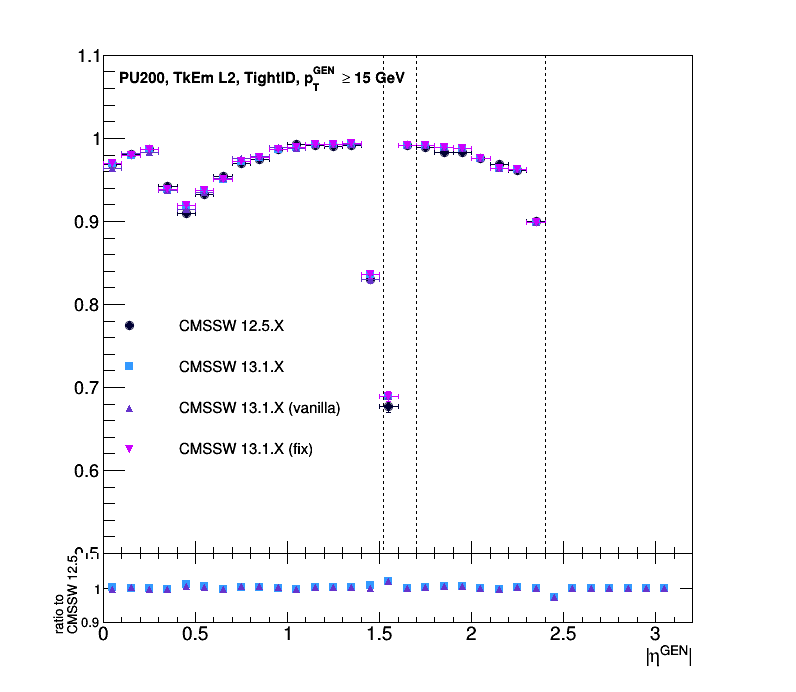

In [162]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2'], 
    ['MenuSta'], ['GENPt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEmL2_MenuSta_GENPt15', page_creator=wc)


In [171]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2'], 
    ['MenuSta'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEmL2_MenuSta_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEmL2_MenuSta_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEmL2_MenuSta_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEmL2_MenuSta_GENPt30.pdf has been created


In [172]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2'], 
    ['MenuPhoIso'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEmL2_MenuPhoIso_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEmL2_MenuPhoIso_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEmL2_MenuPhoIso_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEmL2_MenuPhoIso_GENPt30.pdf has been created


In [173]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleLoose'], ['GENPt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_MenuEleLoose_GENPt15', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_MenuEleLoose_GENPt15!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleLoose_GENPt15.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleLoose_GENPt15.pdf has been created


In [174]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleLoose'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
dm.addRatioHisto(3,0)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_MenuEleLoose_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_MenuEleLoose_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleLoose_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleLoose_GENPt30.pdf has been created


In [175]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleTight'], ['GENPt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_MenuEleTight_GENPt15', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_MenuEleTight_GENPt15!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleTight_GENPt15.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleTight_GENPt15.pdf has been created


In [176]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleTight'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_MenuEleTight_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_MenuEleTight_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleTight_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleTight_GENPt30.pdf has been created


In [177]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['SingleTkEle36'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_SingleTkEle36_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_SingleTkEle36_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_SingleTkEle36_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_SingleTkEle36_GENPt30.pdf has been created


In [178]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig', 'ele-131X-fix']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleIsoTight'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_MenuEleIsoTight_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_MenuEleIsoTight_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleIsoTight_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_MenuEleIsoTight_GENPt30.pdf has been created


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEleL2_SingleIsoTkEle28_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_SingleIsoTkEle28_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_TkEleL2_SingleIsoTkEle28_GENPt30.pdf has been created


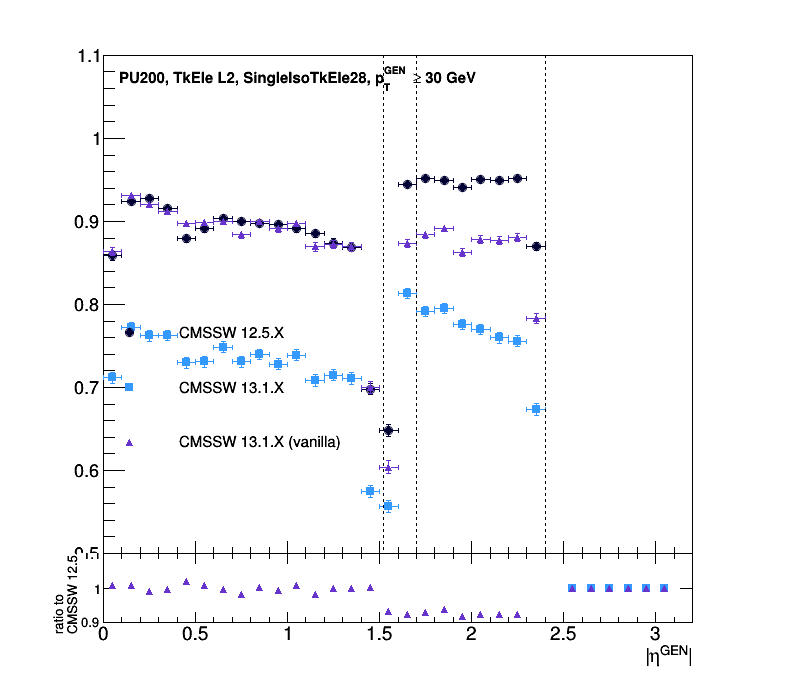

In [130]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['SingleIsoTkEle28'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_TkEleL2_SingleIsoTkEle28_GENPt30', page_creator=wc)


In [ ]:
TP: L1Trk
['TkCTL1Pt5' 'Pt20' 'Pt10' 'TkCTL1' 'all' 'TkCTL1Pt10' 'TkCTL1Pt20' 'Pt5']
['GENEeEtaBC' 'GENEePt15' 'GENEePt30' 'GENEe' 'GEN' 'GENPt30' 'GENPt15'
 'GENEtaF' 'GENEtaC' 'GENEtaBC' 'GENEtaABC']


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_L1Trk_all_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_L1Trk_all_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_L1Trk_all_GENPt30.pdf has been created


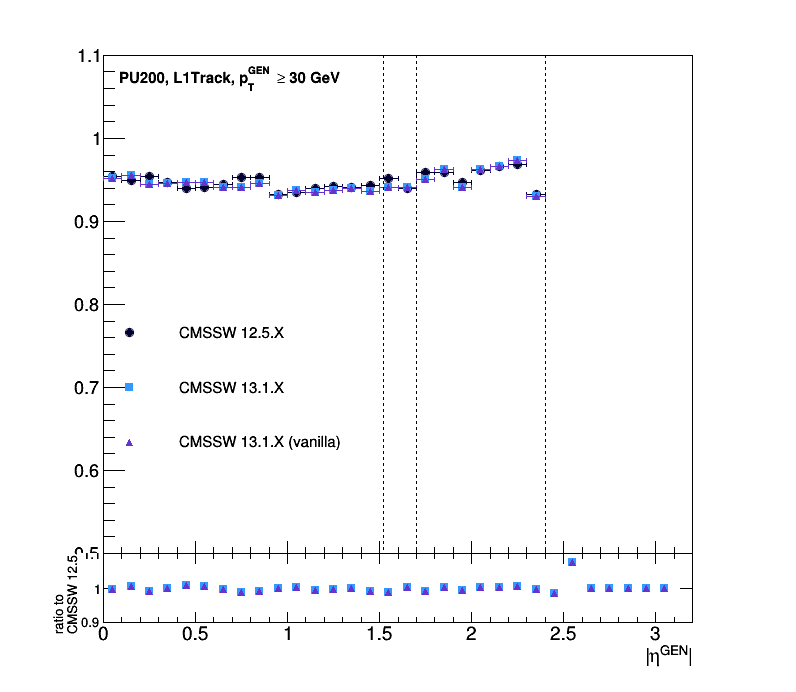

In [150]:
# smps = ['tk-125X', 'tk-131X', 'tk-131X-orig']
smps = ['tk-125X', 'tk-131X', 'tk-131X-orig']

dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['L1Trk'], 
    ['all'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_L1Trk_all_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_L1Trk_TkCTL1_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_L1Trk_TkCTL1_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_L1Trk_TkCTL1_GENPt30.pdf has been created


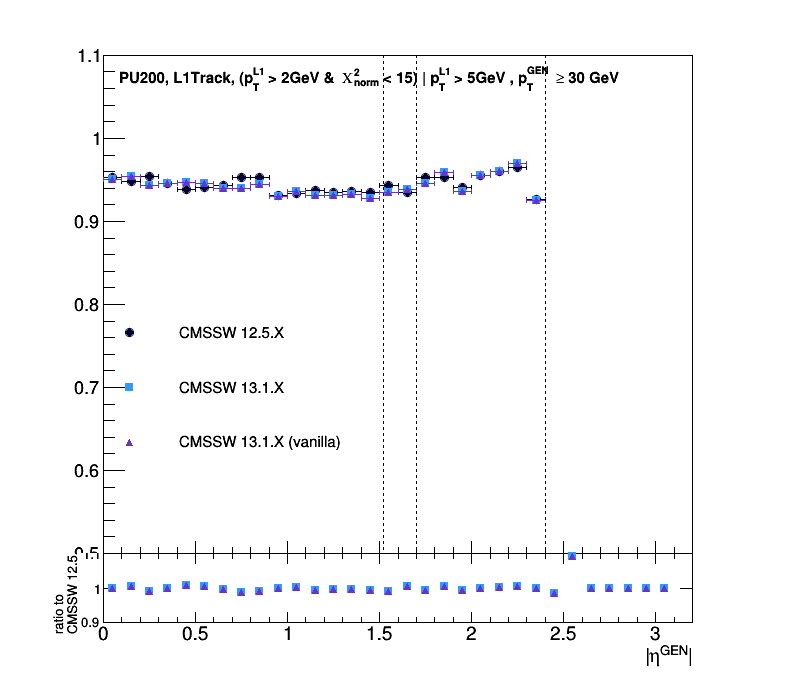

In [151]:
smps = ['tk-125X', 'tk-131X', 'tk-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['L1Trk'], 
    ['TkCTL1'], ['GENPt30'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_L1Trk_TkCTL1_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_L1Trk_TkCTL1_GENPt15!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_L1Trk_TkCTL1_GENPt15.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsEta_L1Trk_TkCTL1_GENPt15.pdf has been created


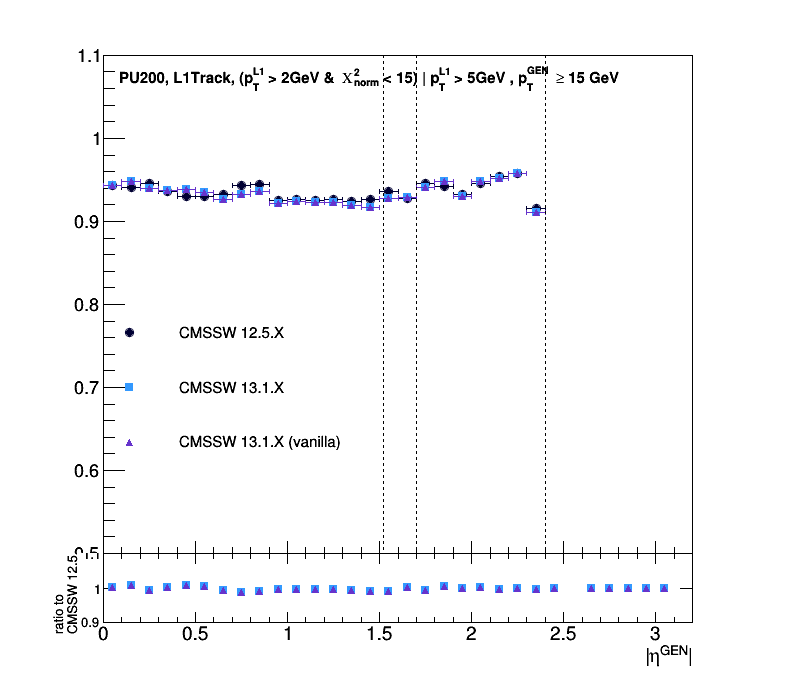

In [152]:
smps = ['tk-125X', 'tk-131X', 'tk-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['L1Trk'], 
    ['TkCTL1'], ['GENPt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

dm.toWeb(name='hEffVsEta_L1Trk_TkCTL1_GENPt15', page_creator=wc)


In [118]:
smps = ['old', 'new']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDTightE'], ['GENPt15', 'GENEePt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.5,
       y_max_ratio=2)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


In [119]:
smps = ['old', 'new']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDTightE'], ['GENEeEtaBC'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=100, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.95,
       y_max_ratio=1.05)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


In [90]:
smps = ['old', 'new']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB'], 
    ['IDTightP'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=100, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.95,
       y_max_ratio=1.05)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


In [122]:
smps = ['old', 'new']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB'], 
    ['all'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=100, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.95,
       y_max_ratio=1.05)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


In [121]:
smps = ['old', 'new']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB'], 
    ['all'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_num.h_pt for his in hsets], labels=labels)
for h in hsets:
    print(h.h_num.h_pt.GetEntries())

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=100, 
#         y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.95,
       y_max_ratio=1.05)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


8809.0
8791.0


Warning in <TH1F::Divide>: Dividing histograms with different bin limits


In [120]:
smps = ['old', 'new']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB'], 
    ['all'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_den.h_pt for his in hsets], labels=labels)
for h in hsets:
    print(h.h_den.h_pt.GetEntries())
dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=100, 
#         y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.95,
       y_max_ratio=1.05)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


9604.0
9606.0


Warning in <TH1F::Divide>: Dividing histograms with different bin limits


In [ ]:
smps = ['pho-12p5', 'pho-compID']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB', 'TkEmEE'], 
    ['all'], ['GENPt15', 'GENEePt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


In [38]:
smps = ['pho-12p5', 'pho-compID']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB', 'TkEmEE'], 
    ['all'], ['GENPt15', 'GENEePt15'], debug=False)

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.1)

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt15', page_creator=wc)


In [28]:
smps = ['pho-12p3', 'pho-12p5', 'pho-compID']

dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)
# hsets, labels, text = hplot.get_histo(
#     histos.HistoSetEff, 
#     smps, 
#     ['PU200'], 
#     ['TkEmEB'], 
#     ['all'], 'GENPt30', debug=False)

# # for hset in hsets:
# #     hset.computeEff(rebin=2)
# dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB', 'TkEmEE'], 
    ['IDTightP'], ['GENPt30', 'GENEePt30'], debug=False)

# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)




dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, v_lines=[1.52, 1.7, 2.4],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.1)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

# dm.toWeb(name='hEffVsEta_TkEm_all_GENPt30', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_TkEm_all_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/test/eff/hEffVsEta_TkEm_all_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/test/eff/hEffVsEta_TkEm_all_GENPt30.pdf has been created


In [39]:
smps = ['ele']
newconfig
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)
# dm.config.colors = [1, 96, 1, 96]
hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['IDTightE'], 'GENPt30', debug=False)

# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)


# hsets, labels, text_2 = hplot.get_histo(
#     histos.HistoSetEff, 
#     smps, 
#     ['PU200'], 
#     ['TkEleEE'], 
#     ['IDCompWP900'], 'GENEePt30', debug=False)
# # for hset in hsets:
# #     hset.computeEff(rebin=2)
# dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=['EE comp.ID'])




# dm.addRatioHisto(0,1)
# # dm.addRatioHisto(2,1)
# # dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        v_lines=[1.52, 1.7, 2.4],
        h_lines=[1.],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.1)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')


# dm.toWeb(name='hEffVsEta_TkEle_IDTight_GENPt30', page_creator=wc)



In [17]:
smps = ['ele-12p5', 'ele-compID']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)
dm.config.colors = ColorPalette()
hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleEB'], 
    ['LooseTkID', 'IDTightE'], 'GENPt30', debug=False)

# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=['EB 12.5', 'EB'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    'ele-12p5', 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDTightE'], 'GENEePt30', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

hsets, labels, text_2 = hplot.get_histo(
    histos.HistoSetEff, 
    'ele-compID', 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDCompWP900', 'IDCompWP800', 'IDCompWP955'], 'GENEePt30', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)




dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        v_lines=[1.52, 1.7, 2.4],
        h_lines=[1.],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.1)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')


dm.toWeb(name='hEffVsEta_TkEle_IDCompWP_GENPt30', page_creator=wc)



No match found for: sample: ['ele-12p5', 'ele-compID'] pu: ['PU200'], tp: ['TkEleEB'], tp_sel: ['LooseTkID', 'IDTightE'], gen_sel: GENPt30, classtype: <class 'python.l1THistos.HistoSetEff'>


TypeError: 'NoneType' object is not iterable

In [18]:
smps = ['ele-12p5', 'ele-compID']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)
dm.config.colors = ColorPalette()
hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleEB'], 
    ['LooseTkID', 'IDTightE'], 'GENPt30', debug=False)

# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=['EB 12.5', 'EB'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleEE', 'TkEleEllEE'], 
    ['IDTightE'], 'GENEePt30', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

# hsets, labels, text_2 = hplot.get_histo(
#     histos.HistoSetEff, 
#     'ele-compID', 
#     ['PU200'], 
#     ['TkEleEE'], 
#     ['IDCompWP900', 'IDCompWP800', 'IDCompWP955'], 'GENEePt30', debug=False)
# # for hset in hsets:
# #     hset.computeEff(rebin=2)
# dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)




dm.addRatioHisto(0,1)
# dm.addRatioHisto(2,1)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
        x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        v_lines=[1.52, 1.7, 2.4],
        h_lines=[1.],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.1)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')


dm.toWeb(name='hEffVsEta_TkEleEll_IDTightE_GENPt30', page_creator=wc)



No match found for: sample: ['ele-12p5', 'ele-compID'] pu: ['PU200'], tp: ['TkEleEB'], tp_sel: ['LooseTkID', 'IDTightE'], gen_sel: GENPt30, classtype: <class 'python.l1THistos.HistoSetEff'>


TypeError: 'NoneType' object is not iterable

In [153]:
wc.publish()

Yes/No: yes
publishing canvas: hEffVsEta_TkEmL2_MenuSta_GENPt15
publishing canvas: hEffVsEta_TkEmL2_MenuSta_GENPt30
publishing canvas: hEffVsEta_TkEmL2_MenuPhoIso_GENPt30
publishing canvas: hEffVsEta_TkEleL2_MenuEleLoose_GENPt15
publishing canvas: hEffVsEta_TkEleL2_MenuEleLoose_GENPt30
publishing canvas: hEffVsEta_TkEleL2_MenuEleTight_GENPt15
publishing canvas: hEffVsEta_TkEleL2_MenuEleTight_GENPt30
publishing canvas: hEffVsEta_TkEleL2_SingleTkEle36_GENPt30
publishing canvas: hEffVsEta_TkEleL2_MenuEleIsoTight_GENPt30
publishing canvas: hEffVsEta_TkEleL2_SingleIsoTkEle28_GENPt30
publishing canvas: hEffVsPt_TkEmL2_MenuSta_GENEtaABC
publishing canvas: hEffVsPt_TkEmL2_MenuSta_GENEtaF
publishing canvas: hEffVsPt_TkEleL2_MenuEleLoose_GENEtaF
publishing canvas: hEffVsPt_TkEleL2_MenuEleLoose_GENEtaABC
publishing canvas: hEffVsPt_TkEleL2_MenuEleTight_GENEtaABC
publishing canvas: hEffVsPt_TkEleL2_MenuEleTight_GENEtaF
publishing canvas: hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaABC
publishing 

In [47]:
def compute_average(name, graph, x_min, x_max):
    npoints = graph.GetN()
    x_buf = graph.GetX()
    x_buf.reshape((npoints,))
    x_data = array.array('d', x_buf)
    y_buf = graph.GetY()
    y_buf.reshape((npoints,))
    y_data = array.array('d', y_buf)
    eff_sum = 0.
    eff_n = 0

    for binn in range(1, npoints):
        if x_data[binn] >= x_min and x_data[binn]<= x_max:
            eff_sum += y_data[binn]
            eff_n += 1
    avg_eff = eff_sum/eff_n
    print (f'graph: {name} avg eff.: {avg_eff}')


In [ ]:
    'TkEmL2': [   'MenuSta@9kHz',
                  'MenuPhoIso',
                  'MenuPhoIsoEtaEB',
                  'SingleIsoTkPho36',
                  'MenuSta@20kHz',
                  'MenuPhoIsoEtaEE',
                  'SingleIsoTkPho36EtaEE',
                  'SingleEGEle51EtaEB',
                  'MenuSta',
                  'MenuStaEtaEB',
                  'SingleEGEle51',
                  'SingleEGEle51EtaEE',
                  'SingleIsoTkPho36EtaEB',
                  'MenuSta@30kHz',
                  'MenuStaEtaEE']}
'TkEleL2': [   'MenuEleLoose',
                   'MenuEleTightEtaEB',
                   'SingleIsoTkEle28TightEtaEE',
                   'MenuEleIsoTight@20kHz',
                   'SingleTkEle36EtaEB',
                   'MenuEleLooseEtaEB',
                   'SingleIsoTkEle28TightEtaEB',
                   'MenuEleLooseEtaEE',
                   'MenuEleIsoTight',
                   'MenuEleIsoTightEtaEB',
                   'MenuEleTight',
                   'SingleTkEle36EtaEE',
                   'MenuEleTight@20kHz',
                   'SingleIsoTkEle28EtaEE',
                   'SingleIsoTkEle28',
                   'MenuEleIsoTight@9kHz',
                   'SingleTkEle36',
                   'MenuEleIsoTight@30kHz',
                   'SingleIsoTkEle28Tight',
                   'MenuEleIsoLooseEtaEB',
                   'MenuEleIsoTightEtaEE',
                   'MenuEleTightEtaEE',
                   'MenuEleTight@9kHz',
                   'MenuEleIsoLooseEtaEE',
                   'SingleIsoTkEle28EtaEB',
                   'MenuEleTight@30kHz',
            
                              'MenuStaEtaEE']}
--- GEN selections:
{   'TkEleL2': [   'GENPt15',
                   'GEN',
                   'GENEtaABC',
                   'GENEePt30',
                   'GENEtaF',
                   'GENEePt15',
                   'GENPt30',
                   'GENEtaFABC'],
    'TkEmL2': [   'GENEtaF',
                  'GENPt30',
                  'GENEePt30',
                  'GENPt15',
                  'GEN',
                  'GENEtaFABC',
                  'GENEePt15',
                  'GENEtaABC']}

## Efficiency vs $p_{T}$

[WebPageCreator]***Warning: overwriting canvas: hEffVsPt_TkEmL2_MenuSta_GENEtaABC!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEmL2_MenuSta_GENEtaABC.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEmL2_MenuSta_GENEtaABC.pdf has been created


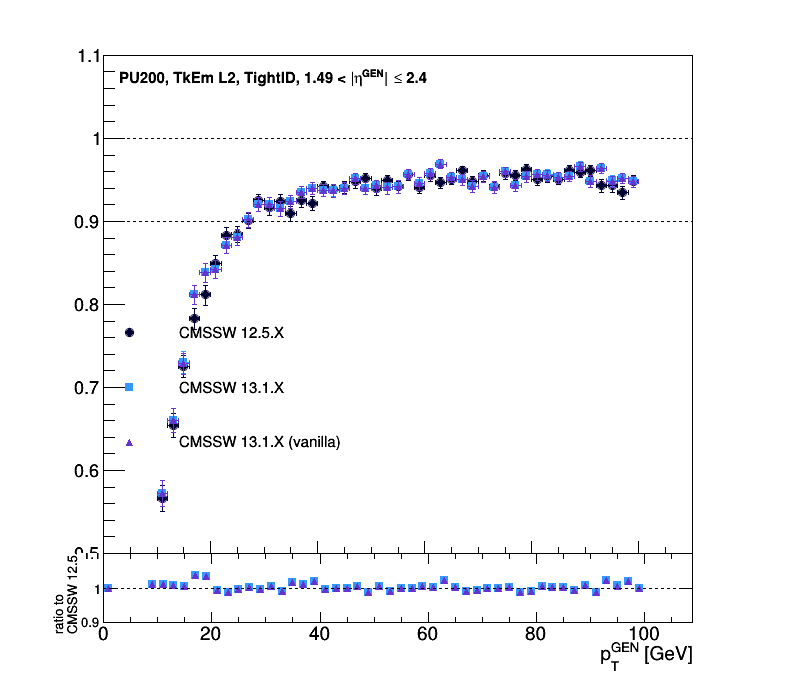

In [114]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2'], 
    ['MenuSta'], ['GENEtaABC'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEmL2_MenuSta_GENEtaABC', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEmL2_MenuSta_GENEtaF.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEmL2_MenuSta_GENEtaF.pdf has been created


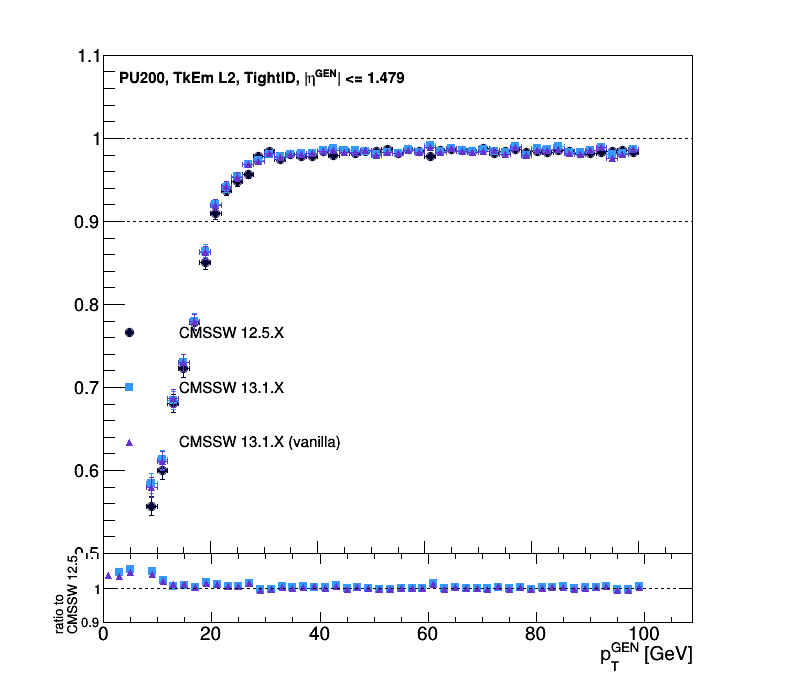

In [113]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2'], 
    ['MenuSta'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEmL2_MenuSta_GENEtaF', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleLoose_GENEtaF.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleLoose_GENEtaF.pdf has been created


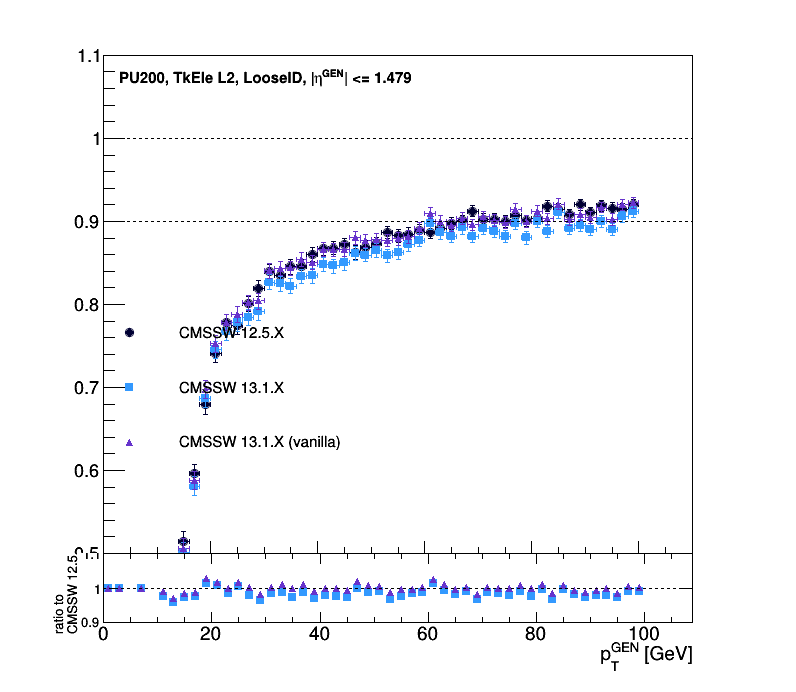

In [115]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleLoose'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_MenuEleLoose_GENEtaF', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleLoose_GENEtaABC.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleLoose_GENEtaABC.pdf has been created


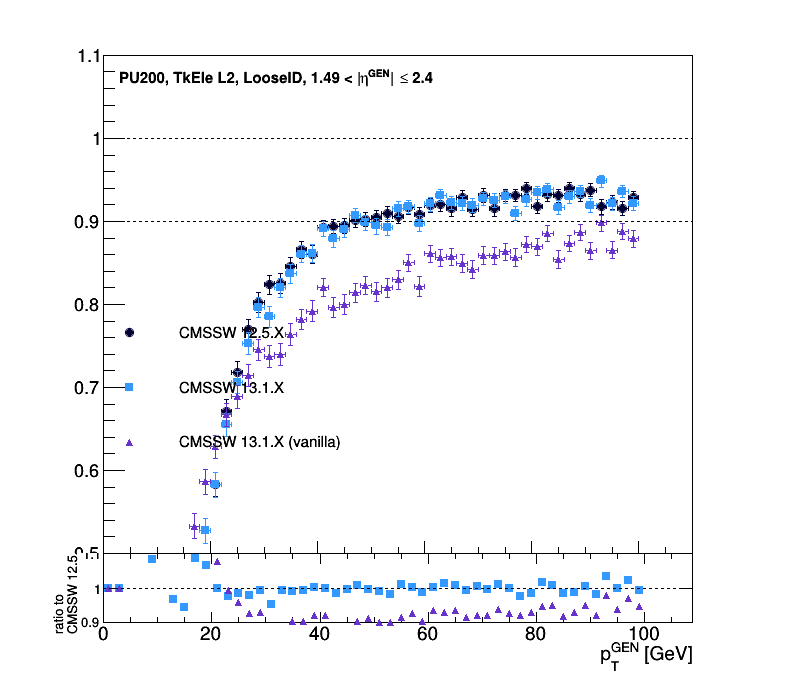

In [116]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleLoose'], ['GENEtaABC'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_MenuEleLoose_GENEtaABC', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleTight_GENEtaABC.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleTight_GENEtaABC.pdf has been created


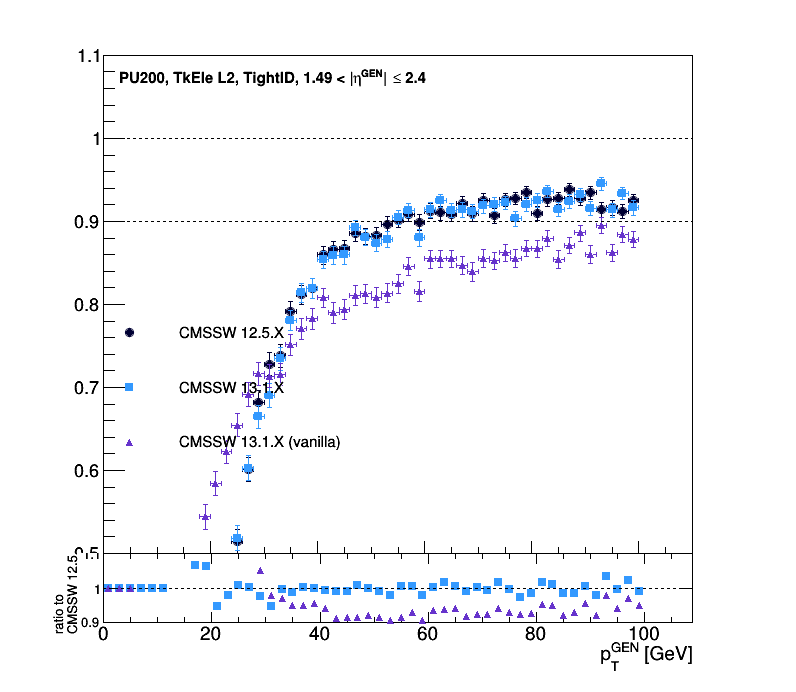

In [117]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleTight'], ['GENEtaABC'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_MenuEleTight_GENEtaABC', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsPt_TkEleL2_MenuEleTight_GENEtaF!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleTight_GENEtaF.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_MenuEleTight_GENEtaF.pdf has been created


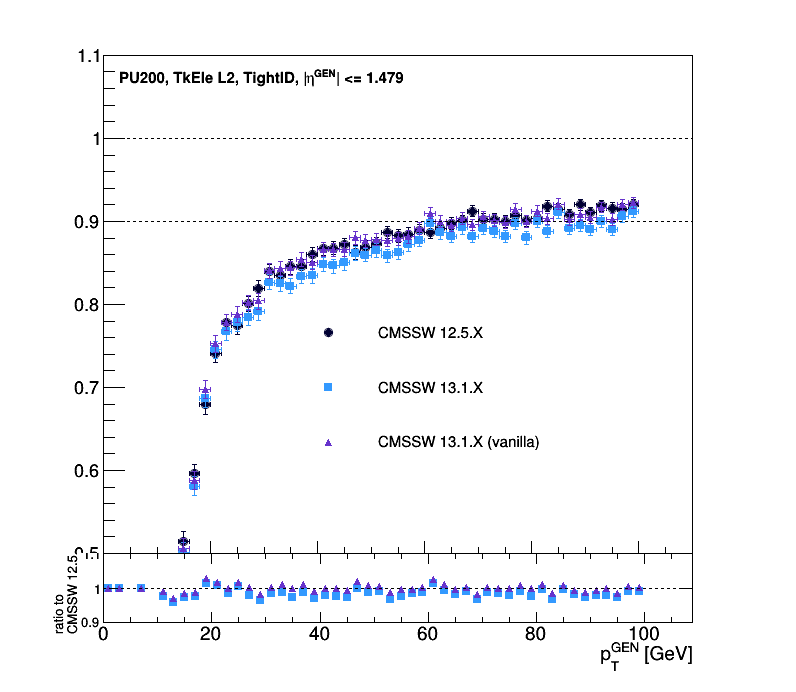

In [120]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.35,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleTight'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_MenuEleTight_GENEtaF', page_creator=wc)


[WebPageCreator]***Warning: overwriting canvas: hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaABC!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaABC.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaABC.pdf has been created


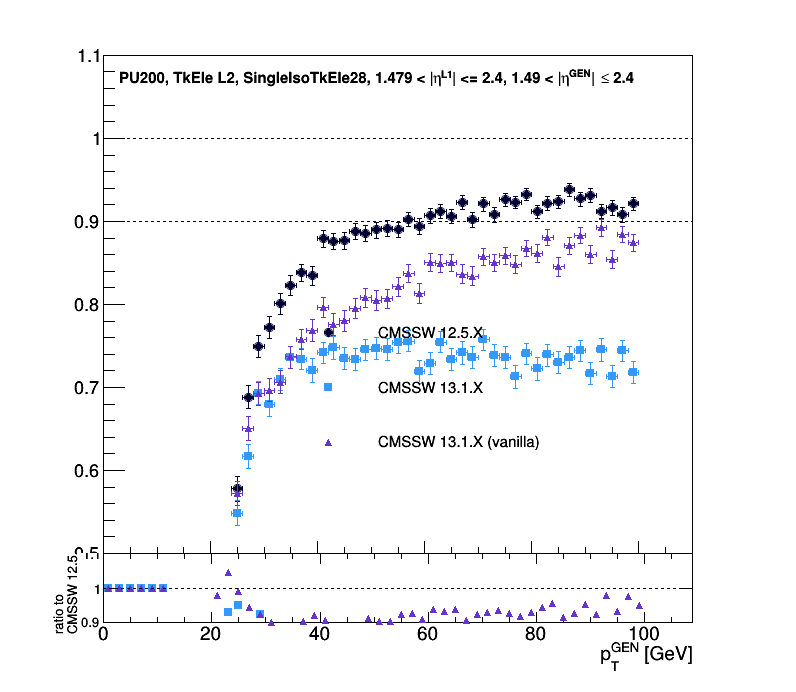

In [132]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.35,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['SingleIsoTkEle28EtaEE'], ['GENEtaABC'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaABC', page_creator=wc)


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaF.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW13.1-MenuValid/eff/hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaF.pdf has been created


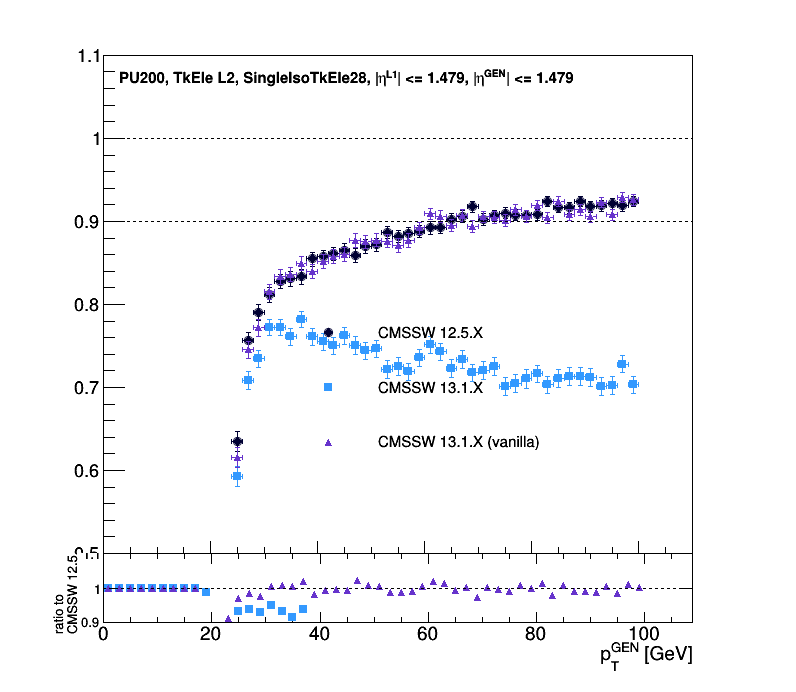

In [133]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.35,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['SingleIsoTkEle28EtaEB'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaF', page_creator=wc)


In [ ]:
smps = ['ele-125X', 'ele-131X', 'ele-131X-orig']
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.1,0.15)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleL2'], 
    ['MenuEleLoose'], ['GENEtaF'], debug=False)

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,1)


dm.draw(text=text, 
#         x_min=0., x_max=3.2, 
        y_min=0.5, y_max=1.1, 
        h_lines=[0.9, 1.0],
#         v_lines=[1.52, 1.7, 2.4],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.1,
       h_lines_ratio=[1.])

dm.toWeb(name='hEffVsPt_TkEleL2_MenuEleLoose_GENEtaF', page_creator=wc)


In [35]:
smps = ['pho-12p5', 'pho-compID']

dm = DrawMachine(newconfig)
dm.config.legend_position = (0.3,0.15)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmEB'], 
    ['all'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.8,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

# dm.toWeb(name='hEffVsPt_TkEmEB_all_EtaF', page_creator=wc)




***Warning: Ratio plot can not be added: list index out of range


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/test/eff/hEffVsPt_TkEmEB_all_EtaF.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/test/eff/hEffVsPt_TkEmEB_all_EtaF.pdf has been created


In [ ]:
--- TP selections:
{   'TkEleL2': [   'SingleTkEle36',
                   'SingleIsoTkEle28EtaEB',
                   'SingleTkEle36EtaEB',
                   'SingleIsoTkEle28',
                   'SingleTkEle36EtaEE',
                   'SingleIsoTkEle28TightEtaEE',
                   'SingleIsoTkEle28EtaEE',
                   'SingleIsoTkEle28Tight',
                   'SingleIsoTkEle28TightEtaEB'],
    'TkEmL2': [   'SingleIsoTkPho36',
                  'SingleEGEle51EtaEB',
                  'SingleEGEle51EtaEE',
                  'SingleIsoTkPho36EtaEE',
                  'SingleEGEle51',
                  'SingleIsoTkPho36EtaEB']}
--- GEN selections:
{   'TkEleL2': [   'GEN',
                   'GENEtaABC',
                   'GENEtaF',
                   'GENEtaFABC',
                   'GENPt15',
                   'GENEePt30',
                   'GENEePt15',
                   'GENPt30'],
    'TkEmL2': [   'GENEtaF',
                  'GENEePt30',
                  'GENEtaABC',
                  'GENEtaFABC',
                  'GENPt15',
                  'GEN',
                  'GENEePt15',
                  'GENPt30']}

In [21]:
     ROOT.kBlue+4,
            ROOT.kAzure+1,
            ROOT.kViolet+5,
            ROOT.kViolet,
            ROOT.kPink-9,
            ROOT.kRed-4,
            ROOT.kOrange+1,
            ROOT.kGreen+1,
            ROOT.kYellow-3


In [19]:

class DPSColorPalette(ColorPalette):
    def __init__(self):  
        ColorPalette.__init__(self)
        self.color_map = {
            # 'Sta': ROOT.kGreen+1,
            # 'Sta': ROOT.kBlue-9,
#             'Sta': ROOT.kCyan-6,
            'Sta': ROOT.kPink-9,
            'TkEm': ROOT.kPink-9,
            'IsoTkEle': ROOT.kBlue+2,
            'TkEle': ROOT.kAzure+1,
#             'EllTkEle': ROOT.kViolet+5,
            'EllTkEle': ROOT.kMagenta+1,

            'sig': ROOT.kAzure-9,
            'bkg': ROOT.kOrange-9,
            'Calo': ROOT.kGreen+1,
            'L1Tk': ROOT.kYellow-3,
            'CompCand': ROOT.kOrange+1,
            'TkEleLoose': ROOT.kPink-9,

        }

    def keys(self):
        return self.color_map.keys()
        
    def setPalette(self, keys):
        self.color_base = []
        for key in keys:
            self.color_base.append(self.color_map[key])


dpsconfig = DrawConfig()
dpsconfig.marker_size = 1
dpsconfig.legend_size=(0.3, 0.3)
dpsconfig.legend_position=(0.3, 0.15)
# newconfig.marker_styles.append(10)
dpsconfig.colors = DPSColorPalette()
dpsconfig.additional_text.append(
    (0.13, 0.91, "#scale[1.5]{CMS} #scale[1.]{Phase-2 Simulation Preliminary}"))
dpsconfig.additional_text.append(
    (0.69, 0.91, "14TeV, 200 PU"))


[WebPageCreator]***Warning: overwriting canvas: hEffVsEta_Ele_Menu_GENPt30!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_Ele_Menu_GENPt30.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_Ele_Menu_GENPt30.pdf has been created


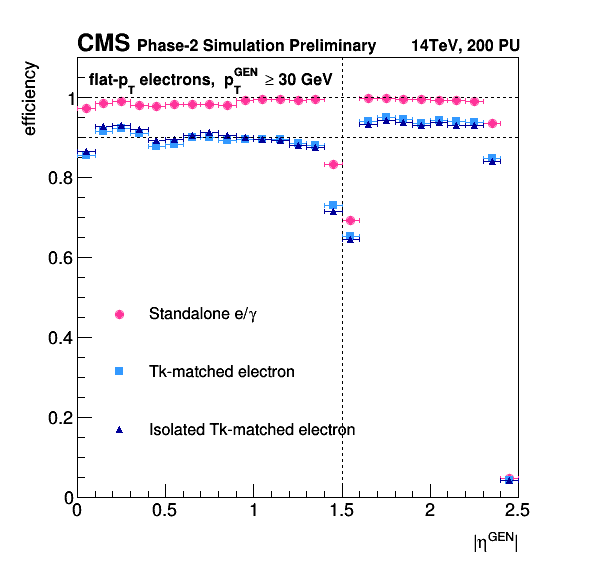

In [22]:
smps = ['ele-menu']

dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.15,0.2)
dm.config.legend_size = (0.4,0.3)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2', 'TkEleL2', ], 
    ['MenuSta', 'MenuEleTight','MenuEleIsoTight', ], 
    'GENPt30', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

text='flat-p_{T} electrons, '+text.split('PU200,')[1]

labels=['Standalone e/#gamma', 
        'Tk-matched electron', 
        'Isolated Tk-matched electron']
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

dm.config.colors.setPalette(['Sta', 'TkEle', 'IsoTkEle'])


dm.draw(text=text, 
        x_min=0, x_max=2.5, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
        v_lines=[1.5],
        do_ratio=False,
        y_min_ratio=0.8,
        y_max_ratio=1.2,
        y_axis_label='efficiency',
#         options='E2'
       )

# dm.legend.SetTextSize(0.04)

# dm.legend.SetTextAlign(12)
# dm.legend.SetFillColor(0)
# dm.legend.SetFillStyle(1001)
# dm.legend.SetBorderSize(0)
dm.canvas.Draw()
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hEffVsEta_Ele_Menu_GENPt30', page_creator=wc)




In [29]:
hplot.data[hplot.data.tp == 'TkEmL2'].tp_sel.unique()

array(['MenuSta@30kHz', 'MenuStaEtaEE', 'SingleEGEle51EtaEE',
       'MenuSta@20kHz', 'SingleIsoTkPho36EtaEE', 'SingleIsoTkPho36',
       'MenuPhoIsoEtaEE', 'MenuStaEtaEB', 'SingleEGEle51', 'MenuSta',
       'MenuSta@9kHz', 'MenuPhoIsoEtaEB', 'SingleEGEle51EtaEB',
       'SingleIsoTkPho36EtaEB', 'MenuPhoIso', 'IDTightPEtaFABC@100kHz',
       'IDTightPPt30', 'Iso0p2', 'Pt10Iso0p1', 'IDTightPPt30Iso0p1',
       'EtaABC@50kHz', 'IDTightPPt30Iso0p2', 'EtaFABC@50kHz',
       'IDTightPEtaF@20kHz', 'Iso0p1', 'IDTightPEtaABC@100kHz',
       'IDTightPEtaFABC@20kHz', 'EtaF@50kHz', 'IDTightPEtaF@100kHz',
       'EtaABC@20kHz', 'IDTightPEtaABC@50kHz', 'IDTightPEtaF@50kHz',
       'IDTightPPt20Iso0p2', 'IDTightPEtaABC@20kHz', 'Pt30Iso0p1', 'Pt20',
       'IDTightPPt20Iso0p1', 'Pt20Iso0p1', 'EtaF@100kHz', 'Pt30',
       'IDTightPIso0p1', 'EtaABC@100kHz', 'EtaF@20kHz', 'Pt30Iso0p2',
       'all', 'IDTightPEtaFABC@50kHz', 'IDTightPPt10Iso0p2', 'Pt10',
       'EtaFABC@20kHz', 'Pt20Iso0p2', 'IDTightPPt1

Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_Ele_Menu_GENPt15.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_Ele_Menu_GENPt15.pdf has been created


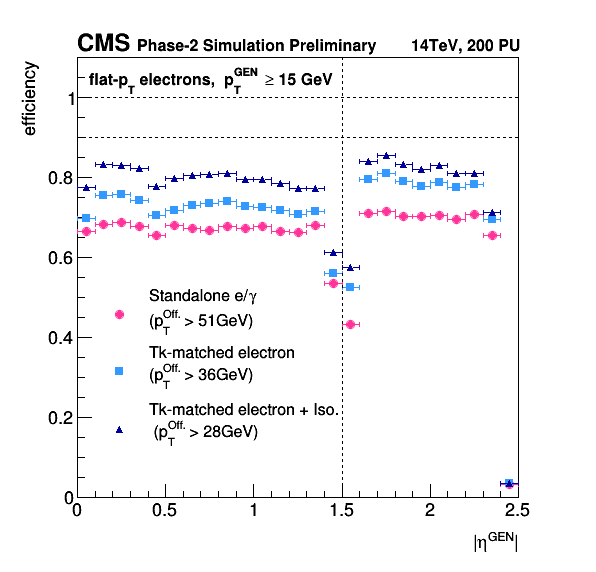

In [30]:
smps = ['ele-menu']

dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.15,0.2)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2', 'TkEleL2', ], 
    ['SingleEGEle51', 'SingleTkEle36','SingleIsoTkEle28Tight', ], 
    'GENPt15', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

text='flat-p_{T} electrons, '+text.split('PU200,')[1]

labels=['#splitline{Standalone e/#gamma}{(p_{T}^{Off.} > 51GeV)}', 
        '#splitline{Tk-matched electron}{(p_{T}^{Off.} > 36GeV)}', 
        '#splitline{Tk-matched electron + Iso.}{ (p_{T}^{Off.} > 28GeV)}']
dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

dm.config.colors.setPalette(['Sta', 'TkEle', 'IsoTkEle'])



dm.draw(text=text, 
        x_min=0, x_max=2.5, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
        v_lines=[1.5],
        do_ratio=False,
        y_min_ratio=0.8,
        y_max_ratio=1.2,
        y_axis_label='efficiency',
#         options='E2'
       )


dm.legend.SetTextAlign(13)
dm.legend.SetFillColor(0)
# dm.legend.SetFillStyle(1001)
dm.legend.SetBorderSize(0)
dm.canvas.Draw()
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hEffVsEta_Ele_Menu_GENPt15', page_creator=wc)




In [31]:


dpsconfig = DrawConfig()
dpsconfig.marker_size = 1
dpsconfig.legend_size=(0.3, 0.3)
dpsconfig.legend_position=(0.3, 0.15)
# newconfig.marker_styles.append(10)
dpsconfig.colors = DPSColorPalette()
dpsconfig.additional_text.append(
    (0.13, 0.91, "#scale[1.5]{CMS} #scale[1.]{Phase-2 Simulation Preliminary}"))
dpsconfig.additional_text.append(
    (0.69, 0.91, "14TeV, 200 PU"))


[WebPageCreator]***Warning: overwriting canvas: hEffVsPt_Ele_Menu!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_Ele_Menu.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_Ele_Menu.pdf has been created


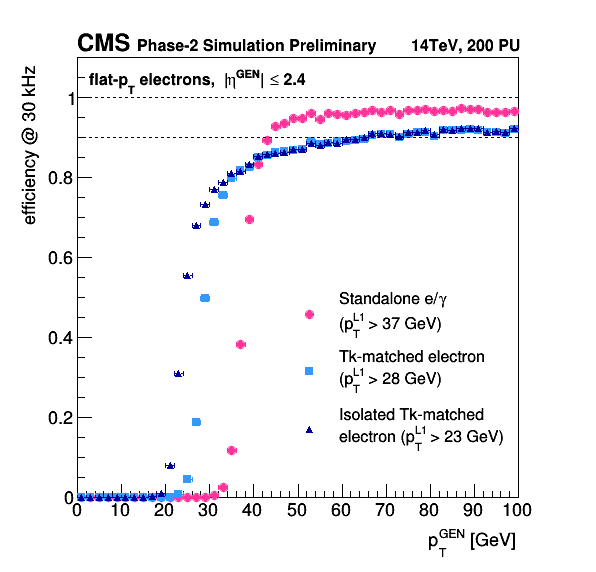

In [49]:
smps = ['ele-menu']

dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.47,0.2)
dm.config.legend_size = (0.4, 0.3)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2', 'TkEleL2', ], 
    ['MenuSta@30kHz', 'MenuEleTight@30kHz','MenuEleIsoTight@30kHz', ], 
    'GENEtaFABC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

text='flat-p_{T} electrons, '+text.split('PU200,')[1]

labels=['#splitline{Standalone e/#gamma}{(p_{T}^{L1} > 37 GeV)}', 
        '#splitline{Tk-matched electron}{(p_{T}^{L1} > 28 GeV)}', 
        '#splitline{Isolated Tk-matched}{electron (p_{T}^{L1} > 23 GeV)}']
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

dm.config.colors.setPalette(['Sta', 'TkEle', 'IsoTkEle'])


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
        do_ratio=False,
        y_min_ratio=0.8,
        y_max_ratio=1.2,
        y_axis_label='efficiency @ 30 kHz',
#         options='E2'
       )


# dm.legend.SetTextAlign(13)
# dm.legend.SetFillColor(0)
# # dm.legend.SetFillStyle(1001)
# dm.legend.SetBorderSize(0)
# dm.canvas.Draw()
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hEffVsPt_Ele_Menu', page_creator=wc)




In [134]:
wc.publish()

Yes/No: yes
publishing canvas: hEffVsEta_TkEmL2_MenuSta_GENPt15
publishing canvas: hEffVsEta_TkEmL2_MenuSta_GENPt30
publishing canvas: hEffVsEta_TkEmL2_MenuPhoIso_GENPt30
publishing canvas: hEffVsEta_TkEleL2_MenuEleLoose_GENPt15
publishing canvas: hEffVsEta_TkEleL2_MenuEleLoose_GENPt30
publishing canvas: hEffVsEta_TkEleL2_MenuEleTight_GENPt15
publishing canvas: hEffVsEta_TkEleL2_MenuEleTight_GENPt30
publishing canvas: hEffVsEta_TkEleL2_SingleTkEle36_GENPt30
publishing canvas: hEffVsEta_TkEleL2_MenuEleIsoTight_GENPt30
publishing canvas: hEffVsEta_TkEleL2_SingleIsoTkEle28_GENPt30
publishing canvas: hEffVsPt_TkEmL2_MenuSta_GENEtaABC
publishing canvas: hEffVsPt_TkEmL2_MenuSta_GENEtaF
publishing canvas: hEffVsPt_TkEleL2_MenuEleLoose_GENEtaF
publishing canvas: hEffVsPt_TkEleL2_MenuEleLoose_GENEtaABC
publishing canvas: hEffVsPt_TkEleL2_MenuEleTight_GENEtaABC
publishing canvas: hEffVsPt_TkEleL2_MenuEleTight_GENEtaF
publishing canvas: hEffVsPt_TkEleL2_SingleIsoTkEle28EtaEE_GENEtaABC
publishing 

Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_Ele_Menu_EtaEB.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_Ele_Menu_EtaEB.pdf has been created


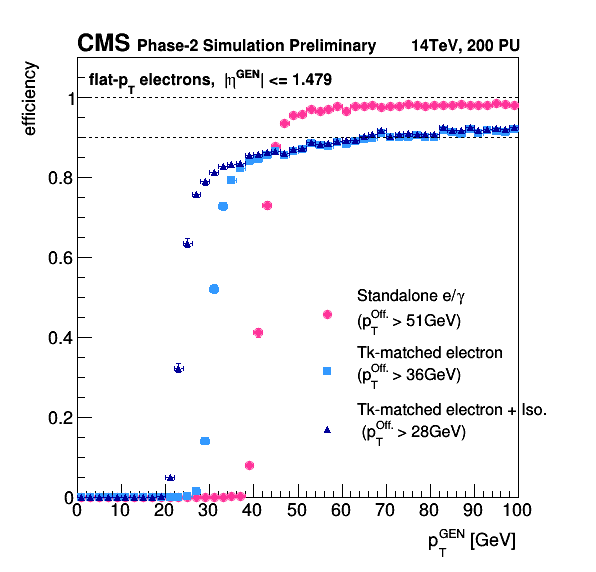

In [34]:
smps = ['ele-menu']
dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.5,0.2)
dm.config.legend_size = (0.4, 0.3)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2', 'TkEleL2', ], 
    ['SingleEGEle51', 'SingleTkEle36','SingleIsoTkEle28Tight', ], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

text='flat-p_{T} electrons, '+text.split('PU200,')[1]

labels=['#splitline{Standalone e/#gamma}{(p_{T}^{Off.} > 51GeV)}', 
        '#splitline{Tk-matched electron}{(p_{T}^{Off.} > 36GeV)}', 
        '#splitline{Tk-matched electron + Iso.}{ (p_{T}^{Off.} > 28GeV)}']
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)



dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
        do_ratio=False,
        y_min_ratio=0.8,
        y_max_ratio=1.2,
        y_axis_label='efficiency',
#         options='E2'
       )


dm.legend.SetTextAlign(13)
dm.legend.SetFillColor(0)
# dm.legend.SetFillStyle(1001)
dm.legend.SetBorderSize(0)
dm.canvas.Draw()
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hEffVsPt_Ele_Menu_EtaEB', page_creator=wc)




Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_Ele_Menu_EtaEE.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_Ele_Menu_EtaEE.pdf has been created


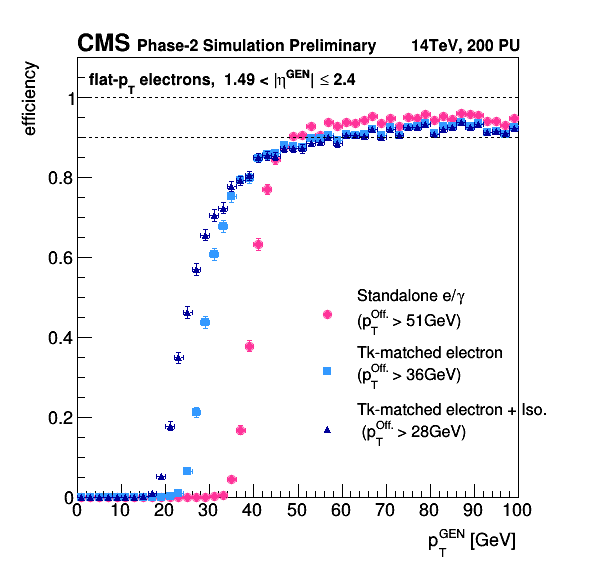

In [35]:
smps = ['ele-menu']

dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.5,0.2)
dm.config.legend_size = (0.4, 0.3)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEmL2', 'TkEleL2', ], 
    ['SingleEGEle51', 'SingleTkEle36','SingleIsoTkEle28Tight', ], 
    'GENEtaABC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

text='flat-p_{T} electrons, '+text.split('PU200,')[1]

labels=['#splitline{Standalone e/#gamma}{(p_{T}^{Off.} > 51GeV)}', 
        '#splitline{Tk-matched electron}{(p_{T}^{Off.} > 36GeV)}', 
        '#splitline{Tk-matched electron + Iso.}{ (p_{T}^{Off.} > 28GeV)}']
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)



dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
        do_ratio=False,
        y_min_ratio=0.8,
        y_max_ratio=1.2,
        y_axis_label='efficiency',
         options='E1'
       )


dm.legend.SetTextAlign(13)
dm.legend.SetFillColor(0)
# dm.legend.SetFillStyle(1001)
dm.legend.SetBorderSize(0)
dm.canvas.Draw()
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hEffVsPt_Ele_Menu_EtaEE', page_creator=wc)




In [36]:
df = hplot.data
df[(df['sample'] == 'ele') & (df.tp=='TkEmL2') & (df.tp_sel=='all')].gen_sel.unique()

array(['GENEtaBCD', 'GEN', 'GENPt30', 'GENEtaF', 'GENPt15', 'GENEtaD',
       'GENEtaBC'], dtype=object)

In [21]:
df[(df['sample'] == 'ele') & ].tp.unique()

array(['TkEleL2', 'TkEleL2Ell', 'TkEleEllEE', 'TkEleEE', 'TkEmL2'],
      dtype=object)

In [16]:
df

,sample,pu,tp,tp_sel,gen_sel,classtype,histo
0,ele-menu,PU200,TkEmL2,SingleEGEle51,GENPt30,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2bc40>
1,ele-menu,PU200,TkEleL2,SingleIsoTkEle28TightEtaEB,GENEtaFABC,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2b520>
2,ele-menu,PU200,TkEmL2,SingleEGEle51EtaEB,GENPt15,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2b490>
3,ele-menu,PU200,TkEmL2,SingleEGEle51EtaEB,GENEePt15,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2bfa0>
4,ele-menu,PU200,TkEmL2,SingleIsoTkPho36EtaEB,GEN,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2bbe0>
...,...,...,...,...,...,...,...
715,tracks,PU200,L1Trk,TkCTL1,GENEePt30,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cf4fa0>
716,tracks,PU200,L1Trk,all,GENEePt30,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cf5000>
717,tracks,PU200,L1Trk,Pt20,GENEePt30,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cf5060>
718,tracks,PU200,L1Trk,TkCTL1Pt10,GENEe,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cf50c0>


In [17]:
df[(df['sample'] == 'tracks') & (df.tp == )]

,sample,pu,tp,tp_sel,gen_sel,classtype,histo
688,tracks,PU200,L1Trk,Pt5,GENEePt15,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cc7ca0>
689,tracks,PU200,L1Trk,TkCTL1Pt10,GENEePt15,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c5f7c0>
690,tracks,PU200,L1Trk,TkCTL1Pt10,GENEeEtaBC,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cc7f70>
691,tracks,PU200,L1Trk,Pt5,GENEeEtaBC,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2bac0>
692,tracks,PU200,L1Trk,Pt10,GENEe,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c2b2e0>
693,tracks,PU200,L1Trk,Pt5,GENEePt30,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c5f730>
694,tracks,PU200,L1Trk,Pt10,GENEePt15,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cc7eb0>
695,tracks,PU200,L1Trk,Pt10,GENEeEtaBC,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cc7940>
696,tracks,PU200,L1Trk,TkCTL1Pt10,GENEePt30,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2c5ec20>
697,tracks,PU200,L1Trk,TkCTL1Pt5,GENEe,<class 'python.l1THistos.HistoSetEff'>,<drawingTools.HProxy object at 0x2a2cc4310>


[WebPageCreator]***Warning: overwriting canvas: hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown.pdf has been created


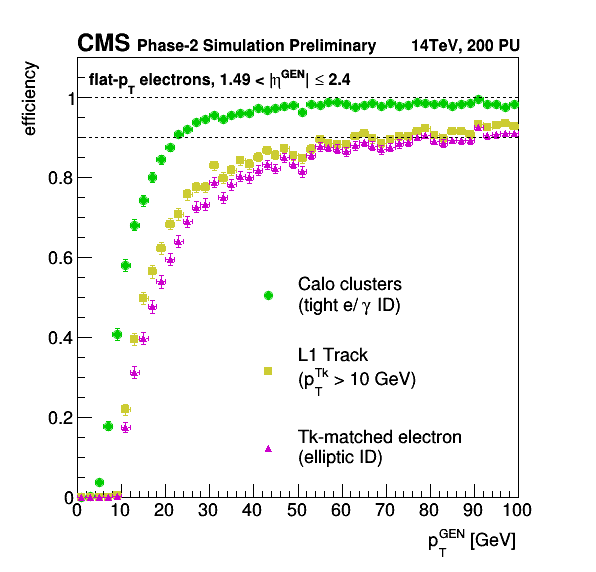

In [26]:


dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.4,0.15)
dm.config.legend_size = (0.4,0.4)



dm.config.colors.setPalette(['Calo', 'L1Tk', 'EllTkEle'])



hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEmL2'], 
    ['IDTightP'], 
    'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)


labels=['#splitline{Calo clusters}{(tight e/#gamma ID)}']

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['tracks'], 
    ['PU200'], 
    ['L1Trk'], 
    ['TkCTL1Pt10'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
labels=['#splitline{L1 Track}{(p_{T}^{Tk} > 10 GeV)}']
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)



hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEllEE'], 
    ['IDTightE'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
labels=['#splitline{Tk-matched electron}{(elliptic ID)}',] 
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)


# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

text = 'flat-p_{T} electrons, 1.49 < |#eta^{GEN}| #leq 2.4'
dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.75,
       y_max_ratio=1.25,
       y_axis_label='efficiency',
       h_lines_ratio=[1.],
#        y_axisl_label_ratio='ratio'
       )

dm.legend.SetTextSize(0.035)
dm.toWeb(name='hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown', page_creator=wc)





In [71]:
hplot.data.tp_sel.unique()


array(['SingleEGEle51', 'SingleIsoTkEle28EtaEB', 'SingleIsoTkEle28',
       'SingleIsoTkPho36EtaEB', 'SingleIsoTkEle28TightEtaEE',
       'SingleIsoTkPho36', 'SingleEGEle51EtaEE', 'SingleIsoTkEle28EtaEE',
       'SingleIsoTkEle28Tight', 'SingleEGEle51EtaEB',
       'SingleIsoTkEle28TightEtaEB', 'SingleTkEle36EtaEB',
       'SingleTkEle36', 'SingleIsoTkPho36EtaEE', 'SingleTkEle36EtaEE',
       'IDTightEEtaFABC@20kHz', 'IDTightEPt30', 'all', 'IDTightS',
       'IDTightEPt10', 'IDTightPPt20', 'Pt30Iso0p1', 'Pt20Iso0p1',
       'IDTightPPt10Iso0p2', 'EtaABC@100kHz', 'IDTightPEtaABC@50kHz',
       'Iso0p1', 'Pt10', 'IDTightPPt10', 'IDTightEIso0p1',
       'IDTightEEtaF@20kHz', 'Pt20Iso0p2', 'Pt10Iso0p2', 'Pt30Iso0p2',
       'IDTightEEtaFABC@50kHz', 'IDTightPIso0p2', 'Pt30',
       'IDTightPPt30Iso0p2', 'IDTightPPt20Iso0p2', 'IDTightEPt20',
       'Iso0p2', 'Pt20', 'IDTightPPt30Iso0p1', 'IDTightSPt10',
       'IDTightPIso0p1', 'EtaF@50kHz', 'EtaFABC@50kHz', 'IDTightEIso0p2',
       'IDTight

Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_Comp_EtaBC_Breakdown.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_Comp_EtaBC_Breakdown.pdf has been created


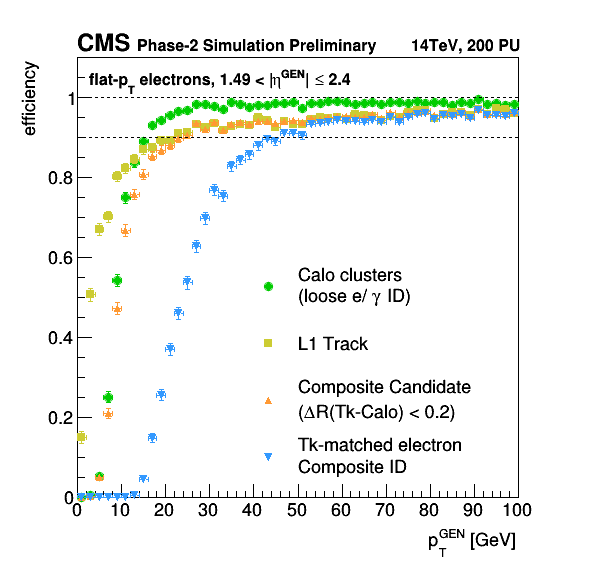

In [27]:

dm = DrawMachine(dpsconfig)
dm.config.legend_position = (0.4,0.15)
dm.config.legend_size = (0.4,0.4)



dm.config.colors.setPalette(['Calo', 'L1Tk', 'CompCand', 'TkEle'])




hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEmL2'], 
    ['all'], 
    'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
labels=['#splitline{Calo clusters}{(loose e/#gamma ID)}']
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['tracks'], 
    ['PU200'], 
    ['L1Trk'], 
    ['TkCTL1'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
labels=['L1 Track']
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele1'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['all'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

labels=['#splitline{Composite Candidate}{(#DeltaR(Tk-Calo) < 0.2)}'] 

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)




hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDTightE', ], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
labels=[
#     '#splitline{Tk-matched electron}{Composite ID (Loose WP)}',
    '#splitline{Tk-matched electron}{Composite ID}',
] 

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)









# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

text = 'flat-p_{T} electrons, 1.49 < |#eta^{GEN}| #leq 2.4'
dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.75,
       y_max_ratio=1.25,
       y_axis_label='efficiency',
       h_lines_ratio=[1.],
#        y_axisl_label_ratio='ratio'
       )

dm.legend.SetTextSize(0.035)

dm.toWeb(name='hEffVsPt_TKEleEE_Comp_EtaBC_Breakdown', page_creator=wc)





In [28]:
wc.publish()

Yes/No: yes
publishing canvas: hEffVsEta_Ele_Menu_GENPt30
publishing canvas: hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown
publishing canvas: hEffVsPt_TKEleEE_Comp_EtaBC_Breakdown


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_EllComp_IDLooseE.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_EllComp_IDLooseE.pdf has been created


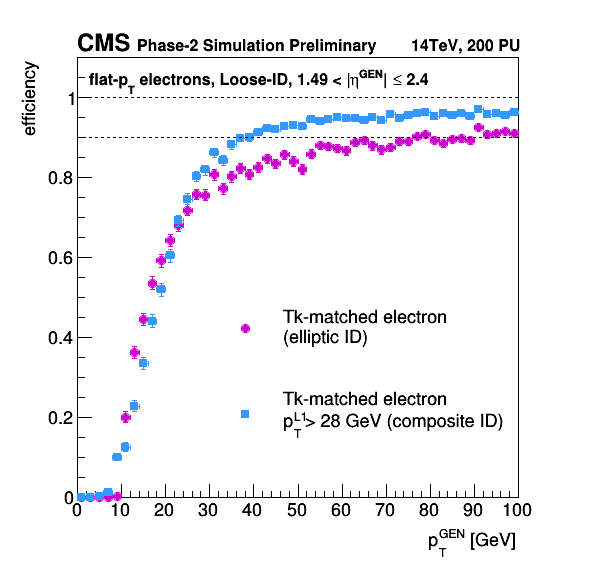

In [29]:

dm = DrawMachine(dpsconfig)

dm.config.legend_size=(0.5, 0.3)
dm.config.legend_position=(0.35, 0.2)
dm.config.colors.setPalette(['EllTkEle', 'TkEle'])

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEllEE'], 
    ['all'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

labels=['#splitline{Tk-matched electron}{(elliptic ID)}',] 

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDCompWP955'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)


labels=['#splitline{Tk-matched electron}{p_{T}^{L1}> 28 GeV (composite ID)}']

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)



# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

text = 'flat-p_{T} electrons, Loose-ID, 1.49 < |#eta^{GEN}| #leq 2.4'
dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.75,
       y_max_ratio=1.25,
       y_axis_label='efficiency',
       h_lines_ratio=[1.],
#        y_axisl_label_ratio='ratio'
       )

dm.legend.SetTextSize(0.035)

dm.toWeb(name='hEffVsPt_TKEleEE_EllComp_IDLooseE', page_creator=wc)





Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_TKEleEE_EllComp_IDLooseE.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_TKEleEE_EllComp_IDLooseE.pdf has been created


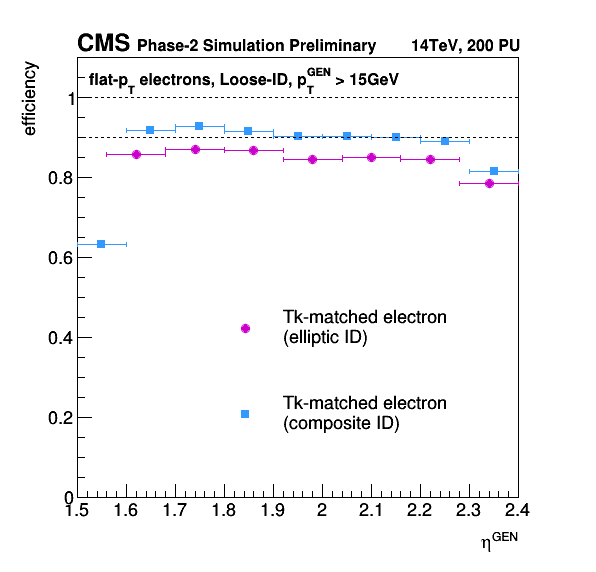

In [30]:

dm = DrawMachine(dpsconfig)

dm.config.legend_size=(0.5, 0.3)
dm.config.legend_position=(0.35, 0.2)
dm.config.colors.setPalette(['EllTkEle', 'TkEle'])

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEllEE'], 
    ['all'], 
    'GENEePt15', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)

labels=['#splitline{Tk-matched electron}{(elliptic ID)}',] 

dm.addHistos([his.h_eff.h_eta.CreateGraph() for his in hsets], labels=labels)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDCompWP955'], 
    'GENEePt15', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)


labels=['#splitline{Tk-matched electron}{(composite ID)}']

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)



# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

text = 'flat-p_{T} electrons, Loose-ID, p_{T}^{GEN} > 15GeV'
dm.draw(text=text, 
        x_min=1.5, x_max=2.4, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.75,
       y_max_ratio=1.25,
       y_axis_label='efficiency',
       h_lines_ratio=[1.],
#        y_axisl_label_ratio='ratio'
       )

dm.legend.SetTextSize(0.035)

dm.toWeb(name='hEffVsEta_TKEleEE_EllComp_IDLooseE', page_creator=wc)





In [31]:
wc.publish()


Yes/No: yes
publishing canvas: hEffVsEta_Ele_Menu_GENPt30
publishing canvas: hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown
publishing canvas: hEffVsPt_TKEleEE_Comp_EtaBC_Breakdown
publishing canvas: hEffVsPt_TKEleEE_EllComp_IDLooseE
publishing canvas: hEffVsEta_TKEleEE_EllComp_IDLooseE


In [41]:
smps = ['ele-12p3', 'ele-12p5']

dm = DrawMachine(newconfig)
dm.config.legend_position = (0.3,0.15)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    smps, 
    ['PU200'], 
    ['TkEleEB'], 
    ['all'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.8,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

# dm.toWeb(name='hEffVsPt_TkEleEB_all_EtaF', page_creator=wc)




NameError: name 'newconfig' is not defined

In [48]:
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12p5'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDTightE'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['ell. ID'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-compID'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['IDCompWP800', 'IDCompWP900', 'IDCompWP955'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)


dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)
dm.addRatioHisto(3,0)
dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.8,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hEffVsPt_TkEleEE_IDCompIDWP_EtaBC', page_creator=wc)




***Warning: Ratio plot can not be added: list index out of range


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5/eff/hEffVsPt_TkEleEE_IDCompIDWP_EtaBC.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5/eff/hEffVsPt_TkEleEE_IDCompIDWP_EtaBC.pdf has been created


In [25]:
import python.calibrations as calib
calib_mgr = calib.CalibManager()
calib_mgr.set_pt_wps_version('data/rate_pt_wps_v152B.82B.json')
rate_pt_wps = calib_mgr.get_pt_wps()
data_selections = calib.rate_pt_wps_selections(
rate_pt_wps, 'TkEmL2')
data_selections = calib.rate_pt_wps_selections(
rate_pt_wps, 'TkEleL2')

print(data_selections)
selm = selections.SelectionManager()
# labels_dict.update(selm.get_labels())
hplot.labels_dict.update(selm.get_labels())


[CalibManager] pt wps json file version: data/rate_pt_wps_v152B.82B.json!
[CalibManager] reading pt wps json file data/rate_pt_wps_v152B.82B.json!
[<Selection n: EtaABC@20kHz, 
	 l:1.49 < |#eta^{L1}| <= 2.4, p_{T}^{L1}>=28.0GeV (@20kHz)> , <Selection n: EtaABC@100kHz, 
	 l:1.49 < |#eta^{L1}| <= 2.4, p_{T}^{L1}>=16.0GeV (@100kHz)> , <Selection n: EtaABC@1000kHz, 
	 l:1.49 < |#eta^{L1}| <= 2.4, p_{T}^{L1}>=99.0GeV (@1000kHz)> , <Selection n: IDTightEEtaABC@20kHz, 
	 l:Tight-TkEle, 1.49 < |#eta^{L1}| <= 2.4, p_{T}^{L1}>=23.0GeV (@20kHz)> , <Selection n: IDTightEEtaABC@100kHz, 
	 l:Tight-TkEle, 1.49 < |#eta^{L1}| <= 2.4, p_{T}^{L1}>=13.0GeV (@100kHz)> , <Selection n: IDTightEEtaABC@1000kHz, 
	 l:Tight-TkEle, 1.49 < |#eta^{L1}| <= 2.4, p_{T}^{L1}>=99.0GeV (@1000kHz)> , <Selection n: EtaF@20kHz, 
	 l:|#eta^{L1}| <= 1.479, p_{T}^{L1}>=40.0GeV (@20kHz)> , <Selection n: EtaF@100kHz, 
	 l:|#eta^{L1}| <= 1.479, p_{T}^{L1}>=21.0GeV (@100kHz)> , <Selection n: EtaF@1000kHz, 
	 l:|#eta^{L1}| <= 1.479

In [32]:
hplot.labels_dict.keys()

dict_keys(['GEN', 'SIM', 'TC', 'TCTrue', 'DEF2D', 'DEF2DTrue', 'HMvDRTrue', 'DEF', 'DEFNC', 'HMvDR', 'HMvDREmInt', 'HMvDREmIntMerged', 'HMvDRRebin', 'HMvDRsTC', 'HMvDRNC0', 'HMvDRNC1', 'DEFMerged', 'DEFCalib', 'HMvDRMerged', 'HMvDRfixed', 'HMvDRcylind10', 'HMvDRcylind5', 'HMvDRcylind2p5', 'HMvDRshape', 'HMvDRshapeDr', 'HMvDRshapeDtDu', 'HMvDRCalib', 'HMvDRcylind10Calib', 'HMvDRcylind5Calib', 'HMvDRcylind2p5Calib', 'HMvDRfixedCalib', 'HMvDRshapeCalib', 'HMvDRshapeDrCalib', 'HMvDRshapeDrCalibNew', 'HMvDRshapeDtDuCalib', 'HMvDRCalibMerged', 'HMvDRshapeCalibMerged', 'HMvDRcylind2p5CalibMerged', 'HMvDRshapeCalib1', 'HMvDRfixedCalib1', 'HMvDRcylind10Calib1', 'HMvDRcylind5Calib1', 'HMvDRcylind2p5Calib1', 'TT', 'SimTT', 'HgcrocTT', 'WaferTT', 'EG', 'EGBRL', 'EGALL', 'L1Trk', 'L1TrkEmu', 'TkEle', 'tkEleEE', 'TkIsoEle', 'TkEGshapeCalib', 'TkEGEmu', 'TkEleBRL', 'tkEleEB', 'tkEleEllAll', 'TkEleALL', 'EgEE', 'EgEB', 'PFEgEE', 'PFNFEgEE', 'EGStaEE', 'EGStaEB', 'PFtkEleEE', 'PFtkEleEB', 'PFNFtkEleEE'

In [96]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['pho'], 
    ['PU200'], 
    ['TkEmL2'], 
    ['IDTightPEtaABC@20kHz', 'EtaABC@20kHz'], 
    'GENEtaABC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





0.0 100.0
0.0 100.0
0.0 100.0


In [97]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['pho'], 
    ['PU200'], 
    ['TkEmL2'], 
    ['IDTightPEtaABC@100kHz', 'EtaABC@100kHz'], 
    'GENEtaABC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





0.0 100.0
0.0 100.0
0.0 100.0


[CalibManager] pt wps json file version: data/rate_pt_wps_v160A.91G.json!
[CalibManager] reading pt wps json file data/rate_pt_wps_v160A.91G.json!
{'TkEmL2': {'MenuSta': {'9': 51.0, '20': 42.0, '30': 37.0}}, 'TkEleL2': {'MenuEleTight': {'9': 43.0, '20': 32.0, '30': 28.0}, 'MenuEleIsoTight': {'9': 36.0, '20': 26.0, '30': 23.0}}, 'TkEleEE': {'EtaABC': {'9': 41.0, '20': 32.0, '30': 29.0}, 'IDTightEEtaABC': {'9': 27.0, '20': 99.0, '30': 99.0}, 'IDCompWP955EtaABC': {'9': 32.0, '20': 24.0, '30': 19.0}}, 'TkEleEllEE': {'IDTightEEtaABC': {'9': 28.0, '20': 22.0, '30': 19.0}, 'EtaABC': {'9': 34.0, '20': 27.0, '30': 23.0}}, 'TkEleEB': {'EtaF': {'9': 47.0, '20': 37.0, '30': 32.0}, 'IDTightEEtaF': {'9': 37.0, '20': 28.0, '30': 26.0}}}
<function Selection.__and__.<locals>.<lambda> at 0x29bc1e290>
<function Selection.__and__.<locals>.<lambda> at 0x29bc1e3b0>
<function Selection.__and__.<locals>.<lambda> at 0x29bc1e4d0>
<function Selection.__and__.<locals>.<lambda> at 0x29bc1e5f0>
<function Selection.

Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_EllComp_IDTightE_9kHz.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsPt_TKEleEE_EllComp_IDTightE_9kHz.pdf has been created


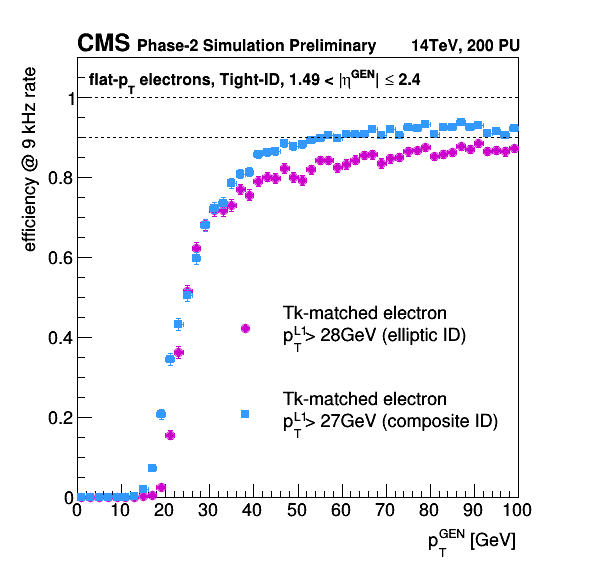

In [32]:

dm = DrawMachine(dpsconfig)

dm.config.legend_size=(0.5, 0.3)
dm.config.legend_position=(0.35, 0.2)
dm.config.colors.setPalette(['EllTkEle', 'TkEle'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEllEE', 'TkEleEE'], 
    ['IDTightEEtaABC@9kHz'], 
    'GENEtaABC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)


labels=['#splitline{Tk-matched electron}{p_{T}^{L1}> 28GeV (elliptic ID)}', 
        '#splitline{Tk-matched electron}{p_{T}^{L1}> 27GeV (composite ID)}']

dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)



text = 'flat-p_{T} electrons, Tight-ID, 1.49 < |#eta^{GEN}| #leq 2.4'
dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=False,
       y_min_ratio=0.75,
       y_max_ratio=1.25,
       y_axis_label='efficiency @ 9 kHz rate',
       h_lines_ratio=[1.],
#        y_axisl_label_ratio='ratio'
       )
dm.legend.SetTextSize(0.035)


dm.toWeb(name='hEffVsPt_TKEleEE_EllComp_IDTightE_9kHz', page_creator=wc)





Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_TKEleEE_EllComp_IDTightE.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5-DPS/eff/hEffVsEta_TKEleEE_EllComp_IDTightE.pdf has been created


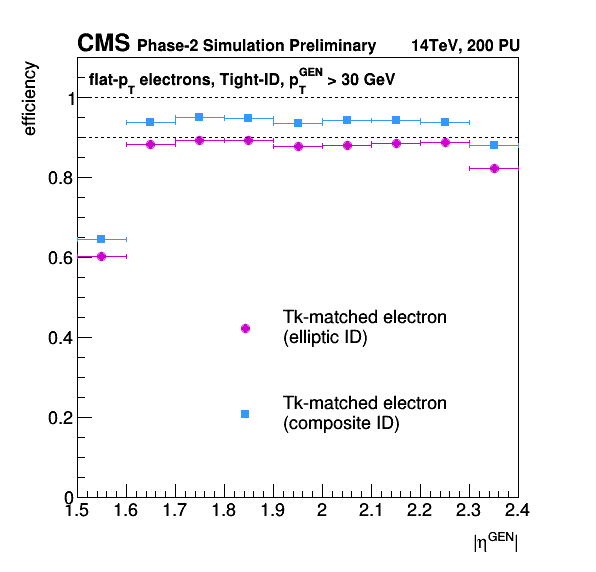

In [33]:

dm = DrawMachine(dpsconfig)

dm.config.legend_size=(0.5, 0.3)
dm.config.legend_position=(0.35, 0.2)
dm.config.colors.setPalette(['EllTkEle', 'TkEle'])

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleEllEE', 'TkEleEE'], 
    ['IDTightE'], 
    'GENEePt30', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)


labels=['#splitline{Tk-matched electron}{(elliptic ID)}', 
        '#splitline{Tk-matched electron}{(composite ID)}']

dm.addHistos([his.h_eff.h_abseta.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)

text = 'flat-p_{T} electrons, Tight-ID, p_{T}^{GEN} > 30 GeV'
dm.draw(text=text, 
        x_min=1.5, x_max=2.4, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=False,
       y_min_ratio=0.75,
       y_max_ratio=1.25,
       y_axis_label='efficiency',
       h_lines_ratio=[1.],
#        y_axisl_label_ratio='ratio'
       )

dm.legend.SetTextSize(0.035)

dm.toWeb(name='hEffVsEta_TKEleEE_EllComp_IDTightE', page_creator=wc)





In [34]:
wc.publish()


Yes/No: yes
publishing canvas: hEffVsEta_Ele_Menu_GENPt30
publishing canvas: hEffVsPt_TKEleEE_Ell_EtaBC_Breakdown
publishing canvas: hEffVsPt_TKEleEE_Comp_EtaBC_Breakdown
publishing canvas: hEffVsPt_TKEleEE_EllComp_IDLooseE
publishing canvas: hEffVsEta_TKEleEE_EllComp_IDLooseE
publishing canvas: hEffVsPt_TKEleEE_EllComp_IDTightE_9kHz
publishing canvas: hEffVsEta_TKEleEE_EllComp_IDTightE


In [60]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele'], 
    ['PU200'], 
    ['TkEleL2'], 
    ['IDTightEEtaABC@100kHz', 'EtaABC@100kHz'], 
    'GENEtaABC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





0.0 100.0
0.0 100.0
0.0 100.0


In [82]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['photon-ref', 'photon-fw'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq1', 'EGq2or3'], 
    'GENEeEtaB', debug=False)
for hset in hsets:
    hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





0.0 100.0
0.0 100.0
0.0 100.0


In [80]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['photon-ref', 'photon-fw'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq1', 'EGq2or3'], 
    'GENEeEtaC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=False,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [41]:
for tp in tps:
    print ('--- TP: {}'.format(tp))
    primitives = histo_primitives[histo_primitives.tp == tp].tp_sel.unique()
    print (histo_primitives[histo_primitives.tp == tp].gen_sel.unique())
    for rate in [20, 100, 1000]:
        print(f'-- rate: {rate}kHz')
        rate_sels = [sel for sel in primitives if f'{rate}kHz' in sel]
        for wp in [95, 98]:
            wp_sel = [sel for sel in rate_sels if f'WP{wp}' in sel]
            print(f'- WP: {wp}%')
            print (wp_sel)
        print([sel for sel in rate_sels if 'WP' not in sel])   
#     print (histo_primitives[histo_primitives.tp == tp].tp_sel.unique())


NameError: name 'tps' is not defined

In [45]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12.3', 'ele-12.3.tp', 'ele-11.1', 'ele-11.1.pf'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['EGq3EtaBC@20kHz'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text + " @ 20kHz", 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
        do_ratio=True,
        y_min_ratio=0.9,
        y_max_ratio=1.2,
        y_axis_label='eff.')
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [112]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12.3', 'ele-12.3.tp', 'ele-11.1', 'ele-11.1.pf'], 
    ['PU200'], 
    ['TkEleEE'], 
    ['EGq3EtaBC@100kHz'], 
    'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text + " @ 100kHz", 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [111]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12.3', 'ele-12.3.tp', 'ele-11.1', 'ele-11.1.pf'], 
    ['PU200'], 
    ['TkEleEB'], 
    ['LooseTkID@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text + " @ 20kHz", 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [114]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12.3', 'ele-12.3.tp', 'ele-11.1', 'ele-11.1.pf'], 
    ['PU200'], 
    ['TkEleEB'], 
    ['LooseTkID@100kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text + " @ 100kHz", 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [136]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.3, 0.1)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12.3', 'ele-12.3.tp', 'ele-11.1', 'ele-11.1.pf'], 
    ['PU200'], 
    ['TkEleEB'], 
    ['LooseTkID@1000kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=labels)

# dm.addRatioHisto(1,0)
# dm.addRatioHisto(2,0)
# dm.addRatioHisto(3,0)
# dm.addRatioHisto(4,0)


dm.draw(text=text + " @ 1000kHz", 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.9,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





### Barrel

#### ISO+p_{T} WP @ 1000kHz

In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@1000kHz', 
     'tkIsoWP98Pt10@1000kHz', 
     'tkIsoWP98Pt20@1000kHz', 
     'tkIsoWP98Pt40@1000kHz', 
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text)


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@1000kHz', 
     'tkIsoWP95Pt10@1000kHz', 
     'tkIsoWP95Pt20@1000kHz', 
     'tkIsoWP95Pt40@1000kHz', 
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text)


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@1000kHz', 
     'tkIsoPVWP98Pt10@1000kHz', 
#      'tkIsoPVWP95Pt10@1000kHz', 
     'tkIsoPVWP98Pt20@1000kHz', 
     'tkIsoPVWP98Pt40@1000kHz', 

     #      'tkIsoPVWP95Pt20@1000kHz'
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)




dm.draw(text=text)


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dph-V11'], ['PU200'], ['PFNFtkEmEB'], [
    '@1000kHz', 
    'pfIsoWP98Pt10@1000kHz', 
#     'pfIsoWP95Pt10@1000kHz', 
    'pfIsoWP98Pt20@1000kHz', 
    'pfIsoWP98Pt40@1000kHz', 
    #     'pfIsoWP95Pt20@1000kHz'
], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text)


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dph-V11'], ['PU200'], ['PFNFtkEmEB'], [
    '@1000kHz', 
    'pfIsoPVWP98Pt10@1000kHz', 
#     'pfIsoPVWP95Pt10@1000kHz', 
    'pfIsoPVWP98Pt20@1000kHz',
    'pfIsoPVWP98Pt40@1000kHz', 

#     'pfIsoPVWP95Pt20@1000kHz'
], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@1000kHz', 
     'tkIsoWP98Pt10@1000kHz', 
     'tkIsoPVWP98Pt10@1000kHz', 
     'pfIsoWP98Pt10@1000kHz', 
     'pfIsoPVWP98Pt10@1000kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dph-V11'], ['PU200'], ['PFNFtkEmEB'], ['@1000kHz', 'tkIsoWP98Pt10@1000kHz', 'tkIsoPVWP98Pt10@1000kHz', 'pfIsoWP98Pt10@1000kHz', 'pfIsoPVWP98Pt10@1000kHz'], 'GENEtaF', debug=False)
for hset in hsets:
    hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, y_min=0.8, y_max=1.1, h_lines=[1., 0.95])


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@1000kHz', 'tkIsoWP98Pt10@1000kHz', 'tkIsoWP95Pt10@1000kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text)


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@1000kHz', 'tkIsoPVWP98Pt10@1000kHz', 'tkIsoPVWP95Pt10@1000kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text)


#### ISO+p_{T} WP @ 20kHz 

In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'tkIsoWP98Pt10@20kHz', 
     'tkIsoWP98Pt20@20kHz', 
     'tkIsoWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'tkIsoPVWP98Pt10@20kHz', 
     'tkIsoPVWP98Pt20@20kHz', 
     'tkIsoPVWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'pfIsoWP98Pt10@20kHz', 
     'pfIsoWP98Pt20@20kHz', 
     'pfIsoWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'pfIsoPVWP98Pt10@20kHz', 
     'pfIsoPVWP98Pt20@20kHz', 
     'pfIsoPVWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'tkIsoWP95Pt40@20kHz', 
     'tkIsoWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'tkIsoPVWP95Pt40@20kHz', 
     'tkIsoPVWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'pfIsoWP95Pt40@20kHz', 
     'pfIsoWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'tkIsoWP98Pt40@20kHz', 
     'tkIsoPVWP98Pt40@20kHz', 
     'pfIsoWP98Pt40@20kHz', 
     'pfIsoPVWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@20kHz', 
     'tkIsoWP98Pt40@20kHz', 
     'tkIsoPVWP98Pt40@20kHz', 
     'pfIsoWP98Pt40@20kHz', 
     'pfIsoPVWP98Pt40@20kHz'], 
    'GENEtaF', debug=False)

for hset in hsets:
    hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, y_min=0.8, y_max=1.1, h_lines=[1., 0.95])


#### ISO+p_{T} WP @ 100kHz

In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'tkIsoWP98Pt10@100kHz', 
     'tkIsoWP98Pt20@100kHz', 
     'tkIsoWP98Pt40@100kHz', 
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'tkIsoPVWP98Pt10@100kHz', 
     'tkIsoPVWP98Pt20@100kHz', 
     'tkIsoPVWP98Pt40@100kHz', 
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'pfIsoWP98Pt10@100kHz', 
     'pfIsoWP98Pt20@100kHz', 
     'pfIsoWP98Pt40@100kHz', 
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'pfIsoPVWP98Pt10@100kHz', 
     'pfIsoPVWP98Pt20@100kHz', 
     'pfIsoPVWP98Pt40@100kHz', 
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'tkIsoWP95Pt20@100kHz',
     'tkIsoWP98Pt20@100kHz',
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'tkIsoPVWP95Pt20@100kHz',
     'tkIsoPVWP98Pt20@100kHz',
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'pfIsoWP95Pt20@100kHz',
     'pfIsoWP98Pt20@100kHz',
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'pfIsoPVWP95Pt20@100kHz',
     'pfIsoPVWP98Pt20@100kHz',
    ], 'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'tkIsoWP95Pt20@100kHz', 
     'tkIsoPVWP95Pt20@100kHz', 
     'pfIsoWP95Pt20@100kHz', 
     'pfIsoPVWP95Pt20@100kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 
     'tkIsoWP98Pt20@100kHz', 
     'tkIsoPVWP98Pt20@100kHz', 
     'pfIsoWP98Pt20@100kHz', 
     'pfIsoPVWP98Pt20@100kHz'], 
    'GENEtaF', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEB'], 
    ['@100kHz', 'tkIsoWP98Pt20@100kHz', 'tkIsoPVWP98Pt20@100kHz', 'pfIsoWP98Pt20@100kHz', 'pfIsoPVWP98Pt20@100kHz'], 
    'GENEtaF', debug=False)
for hset in hsets:
    hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95], y_min=0.8, y_max=1.1)


### Endcap

In [ ]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.4, 0.15)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['tkEmEE'], 
    ['EGq4'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['sim'])

print (text)
hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq6'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['emu EG-ID'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq2or3'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['emu EG-ID noPU'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq1or3'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['emu PF EM-ID noPU'])


dm.addRatioHisto(0,1)
dm.addRatioHisto(2,1)
dm.addRatioHisto(3,1)

dm.draw(text='EG, Tk-em, 1.52 < |#eta^{GEN}| <= 2.4', 
        y_min=0.5, y_max=1.1, h_lines=[.95, 1.],
       do_ratio=True)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [ ]:
newconfig=rleg_config
newconfig.marker_size = 1
newconfig.legend_size=(0.5, 0.3)
newconfig.legend_position=(0.4, 0.15)
newconfig.marker_styles.append(10)
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['tkEleEE'], 
    ['EGq4'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['sim'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['PFNFtkEleEE'], 
    ['EGq6'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['emu EG-ID'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['PFNFtkEleEE'], 
    ['EGq2or3'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['emu EG-ID noPU'])


hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dele-V11'], 
    ['PU200'], 
    ['PFNFtkEleEE'], 
    ['EGq1or3'], 'GENEeEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels=['emu PF EM-ID noPU'])

dm.addRatioHisto(0,1)
dm.addRatioHisto(2,1)
dm.addRatioHisto(3,1)

dm.draw(text='EG, Tk-electron, 1.52 < |#eta^{GEN}| <= 2.4', 
        y_min=0., y_max=1., h_lines=[.95, 1.],
       do_ratio=True)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')





In [ ]:
for tp in ['PFNFtkEmEE']:
    print ('--- TP: {}'.format(tp))
    primitives = histo_primitives[histo_primitives.tp == tp].tp_sel.unique()
    print (histo_primitives[histo_primitives.tp == tp].gen_sel.unique())
    for rate in [20, 100, 1000]:
        print(f'-- rate: {rate}kHz')
        rate_sels = [sel for sel in primitives if f'{rate}kHz' in sel]
        for wp in [95, 98]:
            wp_sel = [sel for sel in rate_sels if f'WP{wp}' in sel]
            print(f'- WP: {wp}%')
            print (wp_sel)
        print([sel for sel in rate_sels if 'WP' not in sel])   
#     print (histo_primitives[histo_primitives.tp == tp].tp_sel.unique())


#### ISO+p_{T} WP @ 100kHz

In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5tkIsoWP98Pt10EtaABC@100kHz', 
     'EGq5tkIsoWP98Pt20EtaABC@100kHz', 
     'EGq5tkIsoWP98Pt40EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5tkIsoPVWP98Pt10EtaABC@100kHz', 
     'EGq5tkIsoPVWP98Pt20EtaABC@100kHz', 
     'EGq5tkIsoPVWP98Pt40EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5pfIsoWP98Pt10EtaABC@100kHz', 
     'EGq5pfIsoWP98Pt20EtaABC@100kHz', 
     'EGq5pfIsoWP98Pt40EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5pfIsoPVWP98Pt10EtaABC@100kHz', 
     'EGq5pfIsoPVWP98Pt20EtaABC@100kHz', 
     'EGq5pfIsoPVWP98Pt40EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5tkIsoWP95Pt10EtaABC@100kHz', 
     'EGq5tkIsoWP98Pt10EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5tkIsoPVWP95Pt10EtaABC@100kHz', 
     'EGq5tkIsoPVWP98Pt10EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5pfIsoWP95Pt10EtaABC@100kHz', 
     'EGq5pfIsoWP98Pt10EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5pfIsoPVWP95Pt10EtaABC@100kHz', 
     'EGq5pfIsoPVWP98Pt10EtaABC@100kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@100kHz', 
     'EGq5tkIsoWP98Pt10EtaABC@100kHz', 
     'EGq5tkIsoPVWP98Pt10EtaABC@100kHz', 
     'EGq5pfIsoWP98Pt10EtaABC@100kHz', 
     'EGq5pfIsoPVWP98Pt10EtaABC@100kHz', 
    ], 
    'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


#### ISO+p_{T} WP @ 20kHz

In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5tkIsoWP98Pt10EtaABC@20kHz', 
     'EGq5tkIsoWP98Pt20EtaABC@20kHz', 
     'EGq5tkIsoWP98Pt40EtaABC@20kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5tkIsoPVWP98Pt10EtaABC@20kHz', 
     'EGq5tkIsoPVWP98Pt20EtaABC@20kHz', 
     'EGq5tkIsoPVWP98Pt40EtaABC@20kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt10EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt20EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt40EtaABC@20kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt10EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt20EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt40EtaABC@20kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5pfIsoWP95Pt20EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt20EtaABC@20kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5pfIsoPVWP95Pt10EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt10EtaABC@20kHz', 
    ], 'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5tkIsoWP98Pt10EtaABC@20kHz', 
     'EGq5tkIsoPVWP98Pt10EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt10EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt10EtaABC@20kHz', 
    ], 
    'GENEtaBC', debug=False)
for hset in hsets:
    hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5tkIsoWP98Pt20EtaABC@20kHz', 
     'EGq5tkIsoPVWP98Pt20EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt20EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt20EtaABC@20kHz', 
    ], 
    'GENEtaBC', debug=False)
for hset in hsets:
    hset.computeEff(rebin=2)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, h_lines=[1., 0.95])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['dph-V11'], 
    ['PU200'], 
    ['PFNFtkEmEE'], 
    ['EGq5EtaABC@20kHz', 
     'EGq5tkIsoWP98Pt20EtaABC@20kHz', 
     'EGq5tkIsoPVWP98Pt20EtaABC@20kHz', 
     'EGq5pfIsoWP98Pt20EtaABC@20kHz', 
     'EGq5pfIsoPVWP98Pt20EtaABC@20kHz', 
    ], 
    'GENEtaBC', debug=False)
for hset in hsets:
    hset.computeEff(rebin=4)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)

dm.draw(text=text, y_min=0.85, y_max=1.05, h_lines=[1., 0.95])


In [ ]:
line_y1p0 = ROOT.TLine(0.,1., 110., 1.)
line_y0p95 = ROOT.TLine(0.,0.95, 110., 0.95)
line_y0p95.SetLineStyle(2)

In [ ]:
hplot.labels_dict['TkEleEL'] = hplot.labels_dict['tkEleEE']
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['PFEgEE','PFNFEgEE','EgEE'], 'EGq5', 'GENEtaBCD', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['tkEleEE','PFtkEleEE','PFNFtkEleEE'], 'EGq5', 'GENEtaBC', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], ['TDR sim.', 'emu. v0', 'emu. v1'], text=text+', TkElectron EE', min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['tkEmEE', 'PFtkEmEE', 'PFNFtkEmEE' ,], 'EGq5', 'GENEtaBC', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], ['TDR sim.', 'emu. v0', 'emu v1'], text=text+', TkEm EE', min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
# hplot.labels_dict['TkEleEL'] = hplot.labels_dict['tkEleEE']
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['tkEleEB','PFtkEleEB','PFNFtkEleEB'], 'LooseTkID', 'GENEtaF', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], ['TDR sim.', 'emu. v0', 'emu. v1'], text=text+', TkElectron EB', min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
# hplot.labels_dict['TkEleEL'] = hplot.labels_dict['tkEleEE']
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['tkEmEB', 'PFtkEmEB','PFNFtkEmEB'], 'all', 'GENEtaF', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], ['TDR sim', 'emu. v0', 'emu. v1'], text=text+' TkEm EB', min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hplot.labels_dict['TkEleEL'] = hplot.labels_dict['tkEleEE']
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11', 'dele-NM','ele-V9'], ['PU200'], ['TkEleEL','tkEleEE'], 'EGq5', 'GENEtaBC', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['hybrid', 'ele-V9'], ['PU200'], 'TkEleEL', 'EGq5Pt25', 'GENEtaBC', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11', 'ele-V9'], ['PU200'], 'TkEleELALL', 'LooseTkID', 'GENEtaF', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['hybrid', 'ele-V9'], ['PU200'], 'TkEleELALL', 'LooseTkID', 'GENEtaF', debug=False)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, h_lines=[0.95, 1.])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], 'EG', 'EGq5Pt25', 'GENEtaBC', debug=False)
text_forprint = 'EG endcap, 1.52 < |#eta^{GEN}| #leq 2.4, p_{T}^{L1} #geq 25GeV'
print dir(hsets[0].h_eff)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, 
     min_y=0, max_y=1.1, y_axis_label='efficiency', h_lines=[0.95, 1],
     do_write=True, write_name='figs/egammaEndcap_EG_EGq5Pt25_GENEtaBC_hEffvPt')



hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], 'EG', 'EGq5Pt25', ['GENEtaDE'])
print labels
text_forprint = 'EG endcap, 2.4 < |#eta^{GEN}| #leq 3.0, p_{T}^{L1} #geq 25GeV'
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, 
     min_y=0, max_y=1.1, y_axis_label='efficiency', h_lines=[0.95, 1],
     do_write=True, write_name='figs/egammaEndcap_EG_EGq5Pt25_GENEtaDE_hEffvPt')


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], 'EG', ['all', 'EGq5'], 'GENEtaBC', debug=False)
text_forprint = 'EG endcap, 1.52 < |#eta^{GEN}| #leq 2.4, p_{T}^{L1} #geq 25GeV'
print dir(hsets[0].h_eff)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, 
     min_y=0, max_y=1.1, y_axis_label='efficiency', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], 'EG', ['all', 'EGq5'], 'GENEtaBC', debug=False)
text_forprint = 'EG endcap, 1.52 < |#eta^{GEN}| #leq 2.4'
print dir(hsets[0].h_eff)
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, 
     min_y=0, max_y=1.1, y_axis_label='efficiency', h_lines=[0.95, 1])



hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], 'EG', 'EGq5', ['GENEtaDE'])
print labels
text_forprint = 'EG endcap, 2.4 < |#eta^{GEN}| #leq 3.0'
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, 
     min_y=0, max_y=1.1, y_axis_label='efficiency', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['EG', 'TkEleEL'], 'EGq5Pt25', 'GENEtaBC')
labels=['calorimeter only', 'track-matched']
legend_position = (0.6, 0.5, 0.86, 0.6)
text_forprint='EG endcap, 1.52 < |#eta^{GEN}| #leq 2.4, p_{T}^{L1} #geq 25GeV'
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, min_y=0, max_y=1.1, 
     y_axis_label='efficiency', h_lines=[0.95, 1],
     legend_position=legend_position,
     do_write=True, write_name='figs/egammaEndcap_TkEle_EGq5Pt25_GENEtaBC_hEffvPt')


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['EGBRL'], ['Pt20', 'Pt20LooseTkID'], ['GENEtaF'])
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0.75, max_y=1.02, y_axis_label='L1 matched to GEN/GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['EGBRL'], ['Pt25', 'Pt25LooseTkID'], ['GENEtaF', 'all'])
for hset in hsets:
    hset.computeEff(rebin=2)

labels=['w/o EG ID', 'w EG ID']
legend_position = (0.6, 0.5, 0.86, 0.6)
text_forprint='EG barrel, |#eta^{GEN}| #leq 1.47, p_{T}^{L1} #geq 25GeV'
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, 
     min_y=0.8, max_y=1.02, min_x=0.0, max_x=100, 
     y_axis_label='efficiency', h_lines=[0.95, 1],
     legend_position=legend_position,
     do_write=True, write_name='figs/EgammaBarrelOnlyCaloEff')


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['EGALL', 'TkEleELALL'], 'Pt25LooseTkID', 'GENEtaF')
labels=['calorimeter only', 'track-matched']
legend_position = (0.6, 0.5, 0.86, 0.6)
text_forprint='EG barrel, |#eta^{GEN}| #leq 1.479, p_{T}^{L1} #geq 25GeV'
draw([his.h_eff.h_pt.CreateGraph() for his in hsets], labels, text=text_forprint, min_y=0, max_y=1.1, 
     y_axis_label='efficiency', h_lines=[0.95, 1],
     legend_position=legend_position,
     do_write=True, write_name='figs/egammaBarrel_TkEle_LooseTkIDPt25_GENEtaF_hEffvPt')


## Efficiency vs fBrem

In [ ]:
sample = 'ele-V9'
for pu in ['PU0', 'PU200']:
    hsets_new = []
    labels_new = []
#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['EG'], ['EGq3'], 'GENEtaBC')
# #     hsets[0].SetMarkerStyle(7)
#     hsets_new.append(hsets[0])
#     labels_new.append("EG standalone")
    
#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['EG'], ['EGq3Pt20'], 'GENEtaBC')
#     hsets_new.append(hsets[0])
#     labels_new.append("EG Pt>20GeV")

    hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['L1Trk'], ['St4Pt2'], 'GENEtaBC')
    hsets_new.append(hsets[0])
    labels_new.append("L1Trk #stubs > 3")

#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['L1Trk'], ['St4Pt10'], 'GENEtaBC')
#     hsets_new.append(hsets[0])
#     labels_new.append("L1Trk p_{T}>10GeV")

    hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['L1TrkEmu'], ['Pt2'], 'GENEtaBC')
    hsets_new.append(hsets[0])
    labels_new.append("L1Trk EMU")

#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['L1TrkEmu'], ['Pt10'], 'GENEtaBC')
#     hsets_new.append(hsets[0])
#     labels_new.append("L1Trk p_{T}>10GeV")

    
    
#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['TkEle'], ['EGq3'], 'GENEtaBC')
#     hsets_new.append(hsets[0])
#     labels_new.append("TkEle")


    
    # drawSeveral([his.hreso.h_ptResVpt for his in hsets], labels,  'COLZ', do_profile=True, text=text)
    draw([his.h_eff.h_fBrem.CreateGraph() for his in hsets_new], labels_new, text=text, min_y=0.75, max_y=1.02, y_axis_label='L1 matched to GEN/GEN', h_lines=[0.95, 1])


In [ ]:
sample = 'ele-V9'
for pu in ['PU0', 'PU200']:
    hsets_new = []
    labels_new = []
#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['EG'], ['EGq3'], 'GENEtaBC')
# #     hsets[0].SetMarkerStyle(7)
#     hsets_new.append(hsets[0])
#     labels_new.append("EG standalone")
    
#     hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['EG'], ['EGq3Pt20'], 'GENEtaBC')
#     hsets_new.append(hsets[0])
#     labels_new.append("EG Pt>20GeV")

    hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['L1TrkEmu'], ['Pt2'], 'GENEtaBC')
    hsets_new.append(hsets[0])
    labels_new.append("L1Trk p_{T}>2GeV")

    hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['L1TrkEmu'], ['Pt10'], 'GENEtaBC')
    hsets_new.append(hsets[0])
    labels_new.append("L1Trk p_{T}>10GeV")

    hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['TkEle'], ['EGq3'], 'GENEtaBC')
    hsets_new.append(hsets[0])
    labels_new.append("TkEle")

    hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, ['TkEG'], ['EGq3M1P10'], 'GENEtaBC')
    hsets_new.append(hsets[0])
    labels_new.append("TkEle")


    
    # drawSeveral([his.hreso.h_ptResVpt for his in hsets], labels,  'COLZ', do_profile=True, text=text)
    draw([his.h_eff.h_fBrem.CreateGraph() for his in hsets_new], labels_new, text=text, min_y=0.75, max_y=1.02, y_axis_label='L1 matched to GEN/GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['tkEleEE', 'PFtkEleEE'], 'EGq4', 'GENEtaBC', debug=False)
draw([his.h_eff.h_fBrem.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, v_lines=[-2.8, -2.4, -1.7, -1.52, 1.52, 1.7, 2.4, 2.8])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['dele-V11'], ['PU200'], ['tkEleEB', 'PFtkEleEB'], 'LooseTkID', 'GENEtaF', debug=False)
draw([his.h_eff.h_fBrem.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, v_lines=[-2.8, -2.4, -1.7, -1.52, 1.52, 1.7, 2.4, 2.8])


## Turn-on curves

In [75]:
hplot.data[(hplot.data.tp == 'TkEleL2') & (hplot.data.gen_sel == 'GENEtaBC') & (hplot.data.gen_sel == 'IDCompWP900Pt10') ]

,sample,pu,tp,tp_sel,gen_sel,classtype,histo


In [1]:
dm = DrawMachine(newconfig)
dm.config.legend_position = (0.3,0.15)
hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12p5', 'ele-compID'], 
    ['PU200'], 
    ['TkEleL2', 'TkEleL2Ell'], 
    ['Pt10', 'Pt20', 'Pt30', 'IDTightEPt40'], 
    'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels=labels)




dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=False,
       y_min_ratio=0.8,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hPtTon_TkEleEE_IDLooseE_EtaBC', page_creator=wc)




NameError: name 'DrawMachine' is not defined

In [95]:
dm = DrawMachine(newconfig)

hsets, labels, text = hplot.get_histo(
    histos.HistoSetEff, 
    ['ele-12p5', 'ele-compID'], 
    ['PU200'], 
    ['TkEleL2', 'TkEleL2Ell'], 
    ['IDTightEPt10', 'IDTightEPt20', 'IDTightEPt30', 'IDTightEPt40'], 
    'GENEtaBC', debug=False)
# for hset in hsets:
#     hset.computeEff(rebin=2)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels=labels)




dm.addRatioHisto(1,0)
dm.addRatioHisto(2,0)


dm.draw(text=text, 
        x_min=0, x_max=100, 
        y_min=0.0, y_max=1.1, 
        h_lines=[1.0, 0.9],
       do_ratio=True,
       y_min_ratio=0.8,
       y_max_ratio=1.2)
# dm.write(name='eg_TDRvsSummer20_matchig_eff')

dm.toWeb(name='hPtTon_TkEleEE_IDToghtE_EtaBC', page_creator=wc)




[WebPageCreator]***Warning: overwriting canvas: hPtTon_TkEleEE_IDToghtE_EtaBC!


Info in <TCanvas::Print>: png file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5/eff/hPtTon_TkEleEE_IDToghtE_EtaBC.png has been created
Info in <TCanvas::Print>: pdf file /var/folders/8z/0424tdz97zsc8klvdy6_xl5r0000gn/T/V91-CMSSW12.5/eff/hPtTon_TkEleEE_IDToghtE_EtaBC.pdf has been created


In [68]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele-ref', 'ele'], ['PU200'], ['PFNFEgEE', 'PFEgEE', 'EgEE'], ['EGq5Pt10'], 'GENEtaBC', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>10GeV - new emu', 'p_{T}>10GeV - new sim', 'p_{T}>10GeV - TDR sim'])

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFNFEgEE', 'PFEgEE', 'EgEE'], ['EGq5Pt20'], 'GENEtaBC', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>20GeV - new emu', 'p_{T}>20GeV - new sim', 'p_{T}>20GeV - TDR sim'])


hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFNFEgEE','PFEgEE', 'EgEE'], ['EGq5Pt30'], 'GENEtaBC', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>30GeV - new emu', 'p_{T}>30GeV - new sim', 'p_{T}>30GeV - TDR sim'])

# dm.addRatioHisto(0,1)

dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


No match found for: sample: dele-V11 pu: ['PU200'], tp: ['PFNFEgEE', 'PFEgEE', 'EgEE'], tp_sel: ['EGq5Pt10'], gen_sel: GENEtaBC, classtype: <class 'python.l1THistos.HistoSetEff'>


TypeError: 'NoneType' object is not iterable

In [83]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt10', 'IDTightPPt10'], 'GEN', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt20', 'IDTightPPt20'], 'GEN', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)


hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt30', 'IDTightPPt30'], 'GEN', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)


hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt40', 'IDTightPPt40'], 'GEN', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)


# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEE', 'tkEleEE'], ['EGq5Pt20'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>20GeV - new sim', 'p_{T}>20GeV - TDR sim'])


# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEE', 'tkEleEE'], ['EGq5Pt30'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>30GeV - new sim', 'p_{T}>30GeV - TDR sim'])

# dm.addRatioHisto(0,1)

dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [94]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt10', 'IDTightPPt10'], 'GENEtaBC', debug=False)
dm.addHistos([his.h_eff.h_pt.CreateGraph() for his in hsets], labels)
dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [92]:

dm = DrawMachine(rleg_config)

# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt10', 'IDTightPPt10'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt20', 'IDTightPPt20'], 'GENEtaBC', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)


# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt30', 'IDTightPPt30'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)


# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, ['ele'], ['PU200'], ['TkEmL2'], ['Pt40', 'IDTightPPt40'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], labels)


# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEE', 'tkEleEE'], ['EGq5Pt20'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>20GeV - new sim', 'p_{T}>20GeV - TDR sim'])


# hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEE', 'tkEleEE'], ['EGq5Pt30'], 'GENEtaBC', debug=False)
# dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>30GeV - new sim', 'p_{T}>30GeV - TDR sim'])

# dm.addRatioHisto(0,1)

dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:

dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEB', 'tkEleEB'], ['LooseTkIDPt10'], 'GENEtaF', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>10GeV - new sim', 'p_{T}>10GeV - TDR sim'])

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEB', 'tkEleEB'], ['LooseTkIDPt20'], 'GENEtaF', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>20GeV - new sim', 'p_{T}>20GeV - TDR sim'])


hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEB', 'tkEleEB'], ['LooseTkIDPt30'], 'GENEtaF', debug=False)
dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['p_{T}>30GeV - new sim', 'p_{T}>30GeV - TDR sim'])

# dm.addRatioHisto(0,1)

dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFEgEE', 'EgEE'], ['EGq5Pt10'], 'GENEtaBC', debug=False)

dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['new sim', 'TDR sim'])

# dm.addRatioHisto(0,1)

dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
dm = DrawMachine(rleg_config)

hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'dele-V11', ['PU200'], ['PFtkEleEE', 'tkEleEE'], ['EGq5Pt30'], 'GENEtaBC', debug=False)

dm.addHistos([his.h_ton.h_pt.CreateGraph() for his in hsets], ['new sim', 'TDR sim'])

# dm.addRatioHisto(0,1)

dm.draw(text=text, y_min=0, y_max=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, 'ele-V11', ['PU200'], ['EG'], ['EGq3Pt30', 'EGq4Pt30', 'EGq5Pt30'], 'GENEtaBC', debug=False)
draw([his.h_ton.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['EG'], ['EGq3Pt30', 'EGq4Pt30', 'EGq5Pt30'], 'GENEtaBC', debug=False)
draw([his.h_ton.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['EG'], ['EGq3Pt30', 'EGq4Pt30', 'EGq5Pt30'], 'GENEtaBC', debug=False)
draw([his.h_ton.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['TkEleEL'], ['EGq3Pt30', 'EGq4Pt30', 'EGq5Pt30'], 'GENEtaBC', debug=False)
draw([his.h_ton.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, ['PU200'], ['TkEleELALL'], ['Pt15', 'Pt30', 'Pt40'], 'GENEtaF', debug=False)
draw([his.h_ton.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])


## Scaling

In [ ]:
def f_yc(x, par):
    return (ROOT.Math.normal_cdf(par[0]*(x[0]-par[1]), par[0]*par[2], 0) - ROOT.TMath.Exp(-par[0]*(x[0]-par[1])+par[0]*par[0]*par[2]*par[2]/2)*ROOT.Math.normal_cdf(par[0]*(x[0]-par[1]), par[0]*par[2], par[0]*par[0]*par[2]*par[2])) * (par[3] - par[4]) + par[4]

tf_yc = ROOT.TF1('tf_yc', f_yc, 0, 100, 5)
tf_yc.SetParameters(1, 20, 4, 1.0, 0.0);
tf_yc.SetParNames("#lambda", "#mu", "#sigma", "Plateau", "Baseline");
tf_yc.SetLineColor(6)
tf_yc.FixParameter(4,0)

tf_yc.SetParLimits(1, 0, 50)

tf_yc.SetParLimits(3, 0.9, 1)
tf_yc.SetParLimits(0, 0, 1)
tf_yc.SetParLimits(2, 0.1, 1)

c = newCanvas()
tf_yc.Draw()
c.Draw()


In [ ]:
sample

In [ ]:
hplot.data[(hplot.data['sample'] == sample) & (hplot.data.tp == 'TkEle')].tp_sel.unique()


In [ ]:
hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, 'PU0', 'TkEle', 'EGq3Pt15', 'GENEtaBC')


print hsets[0].name

In [ ]:
fake_histoname = uuid.uuid4().hex[:6]


In [ ]:
ROOT.TVirtualFitter.SetDefaultFitter("Fumili2")
ROOT.TVirtualFitter.SetPrecision(1e-04)

import array

class HWrapper(object):
    def __init__(self, histo):
        self.histo = histo
    
    def get(self, debug=False):
        return self.histo


# tps_scaling = ['EG', 'TkEleEL']
# tp_sel_scaling = [('EGq3Pt{}', 'EGq3'), ('EGq4Pt{}', 'EGq4'), ('EGq5Pt{}', 'EGq5')]
# pt_points = [10, 15, 20, 25, 30, 40]

sample = 'ele-V9'
samples_scaling = ['ele-V9', 'dele-NM']
tps_scaling = ['EG', 'EGBRL', 'TkEleEL', 'TkEleELBRL', 'tkEleEE', 'tkEleEB']
tp_sel_scaling = [('EGq5Pt{}', 'EGq5'), 
                  ('Pt{}', 'all'),
                  ('Pt{}LooseTkID', 'LooseTkID'),
                  ('Pt{}Iso0p1', 'Iso0p1')]
pt_points = [10, 15, 20, 25, 30, 40]

# sample = 'calib'
# tps_scaling = ['HMvDRshapeDrCalib']
# tp_sel_scaling = [('EmPt{}', 'Em')]
# pt_points = [10, 20, 30]

for sample in samples_scaling:
    for pu in ['PU0', 'PU200']:
        for gen_sel in ['GENEtaBC', 'GENEtaF']:
            for tp in tps_scaling:
                for tp_sel_strings in tp_sel_scaling:
                    pt_95 = []
                    pt_95_err = []
                    print '--- sample: {} {}, tp: {}, sel: {}, gen_sel: {}'.format(sample, pu, tp, tp_sel_strings[1], gen_sel)
                    for pt in pt_points:
    #                     for (i=0; i<ngr; i++)
    #       grint->SetPoint(i, gr->GetX()[i], 0);

                        tp_sel = tp_sel_strings[0].format(pt)
                        hsets, labels, text = hplot.get_histo(histos.HistoSetEff, sample, pu, tp, tp_sel, gen_sel)
                            # drawSeveral([his.hreso.h_ptResVpt for his in hsets], labels,  'COLZ', do_profile=True, text=text)
            #                 draw([his.h_ton.h_pt.CreateGraph() for his in hsets], labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])
                        if hsets is None:

                            continue
                        print '   pt: {}'.format(pt)
                        #                     if pt == 20:
                        tf_yc.SetParameters(0.6, pt, 0.1, 1.0, 0.0)
    #                     else:
    #                         tf_yc.SetParameters(1, 20, 4, 1.0, 0.0)
                        h_eff_vs_pt = [his.h_ton.h_pt.CreateGraph() for his in hsets]

                        result = h_eff_vs_pt[0].Fit(tf_yc, 'EMQRS+')

                        grint = ROOT.TGraphErrors(h_eff_vs_pt[0].GetN())
                        stuff.append(grint)
                        grint.SetTitle("Fitted line with .95 conf. band")
                        for point in range(0, h_eff_vs_pt[0].GetN()):
                            grint.SetPoint(point, h_eff_vs_pt[0].GetX()[point], 0)
                        ROOT.TVirtualFitter.GetFitter().GetConfidenceIntervals(grint)


                        print '------- {}'.format( text)
                        print result.Print()
                        pt095 = tf_yc.GetX(0.95)
                        pt_95.append(pt095)

                        prev_err = 0
                        error = 0
                        for idx,point in enumerate(grint.GetX()):
    #                         print idx, point, grint.GetEY()[idx]
                            if pt095 > point:
                                prev_err = grint.GetEY()[idx]
                            else:
                                error = (prev_err+grint.GetEY()[idx])/2
                                break
                        pt_95_err.append(error)
                        print '       pt th: {}, 95% eff: {}, err: {}'.format(pt, pt095, error)
                        #                 points.append((tp, pu, pt, pt095))
                        draw(h_eff_vs_pt, labels, text=text, min_y=0, max_y=1.1, y_axis_label='L1 matched to GEN and p_{T}>th./L1 matched to GEN', h_lines=[0.95, 1])
                        ROOT.gStyle.SetOptFit(11111)
                        grint.Draw('same')

                    print len(pt_points)
                    print len(pt_95)
                    print len(pt_95_err)
                    print pt_95_err
                    
                    # this allows to simply skip missing combinations of TP and TPsel 
                    # (see previous continue statement in this cell)
                    if len(pt_points) != len(pt_95):
                        continue
                    graph = ROOT.TGraphErrors(len(pt_points), array.array('d', pt_points), 
                                                              array.array('d', pt_95),
                                                              array.array('d', [0.]*len(pt_points)),
                                                              array.array('d', pt_95_err) )
                    graph.SetMarkerStyle(7)
                    graph.SetMarkerColor(2)
                    stuff.append(graph)

                    hplot.data = hplot.data.append({'sample': sample,
                                                    'pu': pu,
                                                    'tp': tp,
                                                    'tp_sel': tp_sel_strings[1],
                                                    'gen_sel': gen_sel,
                                                    'classtype': fake_histoname,
                                                    'histo': HWrapper(graph),},
                                                    ignore_index=True)

                
                

In [ ]:
hplot.data[hplot.data.classtype == fake_histoname]


In [ ]:
hplot.data[hplot.data.classtype == fake_histoname]['sample'].unique()

In [ ]:
scaling_params = pd.DataFrame(columns=['tp', 'tp_sel', 'params', 'sample'])
ROOT.gStyle.SetOptFit(11111)

for sample in hplot.data[hplot.data.classtype == fake_histoname]['sample'].unique():
    print sample
    for pu in hplot.data[
        (hplot.data.classtype == fake_histoname) & 
        (hplot.data['sample'] == sample)].pu.unique():
        for tp in hplot.data[
            (hplot.data.classtype == fake_histoname) & 
            (hplot.data['sample'] == sample) & 
            (hplot.data.pu == pu)].tp.unique():
            for tp_sel in hplot.data[
                (hplot.data.classtype == fake_histoname) & 
                (hplot.data['sample'] == sample) & 
                (hplot.data.pu == pu) & 
                (hplot.data.tp == tp)].tp_sel.unique():
                for gen_sel in hplot.data[
                (hplot.data.classtype == fake_histoname) & 
                (hplot.data['sample'] == sample) & 
                (hplot.data.pu == pu) & 
                (hplot.data.tp == tp) &
                (hplot.data.tp_sel == tp_sel)].gen_sel.unique():
                    hsets, labels, text = hplot.get_histo(fake_histoname, sample, pu, tp, tp_sel, gen_sel)
                    result = hsets[0].Fit('pol1', 'MES+', '', 10, 40)
                    result.GetParams()
                    scaling_params = scaling_params.append({'sample': sample,
                                                            'pu': pu,
                                                            'tp': tp,
                                                            'tp_sel': tp_sel+gen_sel.split('GEN')[1],
                                                            'params': (result.GetParams()[0], result.GetParams()[1])},
                                                              ignore_index=True)
                    draw(hsets, labels, text=text, min_y=0, max_y=60, y_axis_label='p_{T} @ 95% eff. [GeV] ', x_axis_label='p_{T} thresh. [GeV]')

###### 

In [ ]:
scaling_params

In [ ]:
scaling_params.to_csv(r'scaling_params_{}.csv'.format(version_NM))

In [ ]:
eta_boundaries_fiducial = [-5, -4, -3,-2.5 ,-1.5, -0.5, 0.5, 1.5, 2.5, 3, 4, 5]
eta_boundaries = []
phi_boundaries_fiducial = []


eta_overlap = 0.25
phi_overlap = 0.25
phiSlices = 9

phiWidth = 2*math.pi/phiSlices


phi_boundaries = []


for ieta,eta_low_fiducial in enumerate(eta_boundaries_fiducial):
    if ieta>=len(eta_boundaries_fiducial)-1:
        break
    eta_high_fiducial = eta_boundaries_fiducial[ieta+1]
    print 'fiducial boundaries: {}, {}'.format(eta_low_fiducial, eta_high_fiducial)
    eta_low = eta_low_fiducial - eta_overlap
    eta_high = eta_high_fiducial + eta_overlap
    eta_boundaries.append((eta_low, eta_high))
    
    
    
for iphi in range(0,9):
    phiCenter = (iphi+0.5)*phiWidth-math.pi
    print iphi,phiCenter
    phi_low_fiducial = phiCenter - phiWidth/2.
    phi_high_fiducial = phiCenter+phiWidth/2.
    
    print 'fiducial boundaries: {}, {}'.format(phi_low_fiducial, phi_high_fiducial)
    phi_boundaries_fiducial.append(phi_low_fiducial)
    
    phi_low = phi_low_fiducial - phi_overlap
    if phi_low < -1*math.pi:
        phi_low = math.pi-phi_overlap
    phi_high = phi_high_fiducial + phi_overlap
    if phi_high > math.pi:
        phi_high = -1*math.pi+phi_overlap
    
    phi_boundaries.append((phi_low, phi_high))
    print 'boundaries: {} {}'.format(phi_low, phi_high)
    
    
phi_boundaries_fiducial.append(math.pi)
print "FIDUCIAL"
print eta_boundaries_fiducial
print phi_boundaries_fiducial

print "ACTUAL"
print phi_boundaries
print eta_boundaries

In [ ]:
class pippo:
    def __init__(self, mystring=''):
        print mystring
        return
    
pippo_l = lambda : pippo(mystring="ciccio")

pippo_l()